In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

### Notebook for data preprocessing

-> From ROOT TTree to h5py file

### Basic modules

In [32]:
import pandas as pd
import numpy as np
import os
import h5py
import pickle

import matplotlib
import matplotlib.pyplot as plt

### Input ROOT files

In [33]:
import uproot

data_dir = '/data_CMS/cms/portales/HHresonant_SKIMS/trimmed_samples/'
work_dir = '/data_CMS/cms/portales/HHresonant_DANN/'

mass_point = 'All' # Resonance mass in GeV

sig_in = data_dir + 'Radion' + mass_point + '_allperiods_resDNN_selfix.root'
#sig_in = data_dir + 'Radion' + mass_point + '_2018_allperiods_resDNN_selfix.root'
bkg_in = data_dir + 'TT_all_sel.root'
#bkg_in = data_dir + 'DY_all_sel.root'

sigtree = uproot.open(sig_in)['HTauTauTree']
bkgtree = uproot.open(bkg_in)['HTauTauTree']

### Mass planing

In [34]:
def get_planing_weight(mass_dist):

    # Retrieve upper and lower bounds
    min_mass, max_mass = np.min(mass_dist), np.max(mass_dist)
    diff = max_mass - min_mass
    min_mass, max_mass = min_mass - 0.10*diff, max_mass + 0.10*diff
    
    # split in bins
    nbins = np.linspace(min_mass,max_mass,1000)
    
    # get bins centers
    masspts = 0.5*(nbins[1:] + nbins[:-1])  
    
    # get fraction of entries per bin
    vals, _ = np.histogram(mass_dist, bins=nbins, density=True)  
    
    # interpolate
    from scipy import interpolate
    interp = interpolate.interp1d(masspts, vals, bounds_error=False)   
    
    # Compute weights
    probs= interp(mass_dist)    
    weights = np.nansum(probs)/probs
    weights/=np.nanmean(weights) 
    
    return weights

### ROOT file to pandas DataFrame 

In [45]:
inFeatures = [
    'HHKin_mass_raw',
    'mT1',
    'mT2',
#    'dau1_pt',
    'dau1_decayMode',
    'dau2_decayMode',
#    'bjet1_pt',
    'bjet1_CvsL',
    'bjet1_CvsB',
    'tauH_SVFIT_mass',
    'tauHsvfitMet_deltaPhi',
#    'ditau_deltaR',
    'bH_mass',
    'HHKin_chi2',
    'HHsvfit_deltaPhi',
    'ditau_deltaR_per_tauH_MET_pt',
    #'DNNoutSM_kl_1'
]

fourVect = [
    'METx',
    'METy',
    'dau1_pt',
    'dau1_eta',
    'dau1_phi',
    'dau1_e',
    'dau2_pt',
    'dau2_eta',
    'dau2_phi',
    'dau2_e',
    'bjet1_pt',
    'bjet1_eta',
    'bjet1_phi',
    'bjet1_e',
    'bjet2_pt',
    'bjet2_eta',
    'bjet2_phi',
    'bjet2_e',
    'VBFjet1_pt',
    'VBFjet1_eta',
    'VBFjet1_phi',
    'VBFjet1_e',
    'VBFjet2_pt',
    'VBFjet2_eta',
    'VBFjet2_phi',
    'VBFjet2_e',
]

#TODO: remove unwanted weights from list, check weights applied only to specific samples/regions
eventWeights = [
    'MC_weight',
    'totalWeight',
    'prescaleWeight',
    'L1pref_weight',
    'PUjetID_SF',
    'PUReweight',
    'bTagweightL',
    'bTagweightM',
    'bTagWeightT',
    'TTtopPtreweight',
    'trigSF',
    'trigSF_single',
    'trigSf_cross',
    'VBFtrigSF',
    'FakeRateSF',
    'jetFakeSF',
    'IdAndIsoSF_MVA',
    'IdAndIsoSF_deep',
    'IdAndsoSF_deep_pt',
    'IdAndIsoAndFakeSF_MVA',
    'IdAndIsoSFAndFakeSF_deep',
    'IdAndsoSFAndFakeSF_deep_pt',
    'FakeRateSF_MVA',
    'FakeRateSF_deep',
    'customTauIdSF',
    'DYscale_LL',
    'DYscale_MM',
    'DYscale_MH',
    'DYscale_MTT',    
]

cuts = '(HHKin_mass_raw>0) & (HHKin_mass_raw<1500.)'

### turn TTree into pandas dataframes
sigEvents = sigtree.arrays(inFeatures+fourVect, cuts, library='pd')
bkgEvents = bkgtree.arrays(inFeatures+fourVect, cuts, library='pd')


### Add class labels
sigEvents.insert(0,'Class', 1, True)
bkgEvents.insert(0,'Class', 0, True)


### Add "Mass bin" classes (TODO: add binning optimiser here too !)
HHmass_sig = pd.cut(sigEvents.HHKin_mass_raw, bins=[-1, 258, 265, 271, 277, 283, 289, 295, 302, 309, 317, 325, 335, 346, 358, 374, 394, 420, 459, 531, 999999], labels=range(20))
HHmass_bkg = pd.cut(bkgEvents.HHKin_mass_raw, bins=[-1, 258, 265, 271, 277, 283, 289, 295, 302, 309, 317, 325, 335, 346, 358, 374, 394, 420, 459, 531, 999999], labels=range(20))
sigEvents.insert(0,'massBin', HHmass_sig, True)
bkgEvents.insert(0,'massBin', HHmass_bkg, True)

### Get labels in separated arrays
sigEvents_labels = np.ravel(sigEvents.Class)
bkgEvents_labels = np.ravel(bkgEvents.Class)

sigEvents_massBin = np.ravel(HHmass_sig)
bkgEvents_massBin = np.ravel(HHmass_bkg)


### Get Planing weights
sigEvents_planWeights = get_planing_weight(np.array(sigEvents.HHKin_mass_raw))
bkgEvents_planWeights = get_planing_weight(np.array(bkgEvents.HHKin_mass_raw))

sigEvents.insert(0,'w_planing', sigEvents_planWeights)
bkgEvents.insert(0,'w_planing', bkgEvents_planWeights)

Events = pd.concat([sigEvents,bkgEvents])

### Compute additional features

In [46]:
from lumin.data_processing.hep_proc import delta_r

addFeatures = ['dphi_tautau', 'dphi_bb', 'dphi_VBF',
               'deta_tautau', 'deta_bb', 'deta_VBF',
               'dr_tautau',   'dr_bb',   'dr_VBF']

Events[ "dphi_tautau" ] = np.abs( Events.dau1_phi    - Events.dau2_phi    )
Events[ "dphi_bb"     ] = np.abs( Events.bjet1_phi   - Events.bjet2_phi   )
Events[ "dphi_VBF"    ] = np.abs( Events.VBFjet1_phi - Events.VBFjet2_phi )

Events[ "deta_tautau" ] = np.abs( Events.dau1_eta    - Events.dau2_eta    )
Events[ "deta_bb"     ] = np.abs( Events.bjet1_eta   - Events.bjet2_eta   )
Events[ "deta_VBF"    ] = np.abs( Events.VBFjet1_eta - Events.VBFjet2_eta )

Events[ "dr_tautau" ] = np.abs(delta_r( Events.dphi_tautau, Events.deta_tautau ))
Events[ "dr_bb"     ] = np.abs(delta_r( Events.dphi_bb,     Events.deta_bb     ))
Events[ "dr_VBF"    ] = np.abs(delta_r( Events.dphi_VBF,    Events.deta_VBF    ))



### Feature sets 

In [47]:
targ_class = 'Class'
targ_mass = 'massBin'
weight_feat = 'w_planing'
cat_feats = ['dau1_decayMode','dau2_decayMode']

base_cont_feats = [f for f in inFeatures if f not in cat_feats]
fourVec_cont_feats = [f for f in fourVect if f not in cat_feats+base_cont_feats]
add_cont_feats = [f for f in addFeatures if f not in cat_feats+base_cont_feats+fourVec_cont_feats]

cont_feats = base_cont_feats+add_cont_feats+fourVec_cont_feats

train_feats = cat_feats+cont_feats
print(cat_feats)
print(cont_feats)

['dau1_decayMode', 'dau2_decayMode']
['HHKin_mass_raw', 'mT1', 'mT2', 'bjet1_CvsL', 'bjet1_CvsB', 'tauH_SVFIT_mass', 'tauHsvfitMet_deltaPhi', 'bH_mass', 'HHKin_chi2', 'HHsvfit_deltaPhi', 'ditau_deltaR_per_tauH_MET_pt', 'dphi_tautau', 'dphi_bb', 'dphi_VBF', 'deta_tautau', 'deta_bb', 'deta_VBF', 'dr_tautau', 'dr_bb', 'dr_VBF', 'METx', 'METy', 'dau1_pt', 'dau1_eta', 'dau1_phi', 'dau1_e', 'dau2_pt', 'dau2_eta', 'dau2_phi', 'dau2_e', 'bjet1_pt', 'bjet1_eta', 'bjet1_phi', 'bjet1_e', 'bjet2_pt', 'bjet2_eta', 'bjet2_phi', 'bjet2_e', 'VBFjet1_pt', 'VBFjet1_eta', 'VBFjet1_phi', 'VBFjet1_e', 'VBFjet2_pt', 'VBFjet2_eta', 'VBFjet2_phi', 'VBFjet2_e']


### Pre-processessed features drawing 

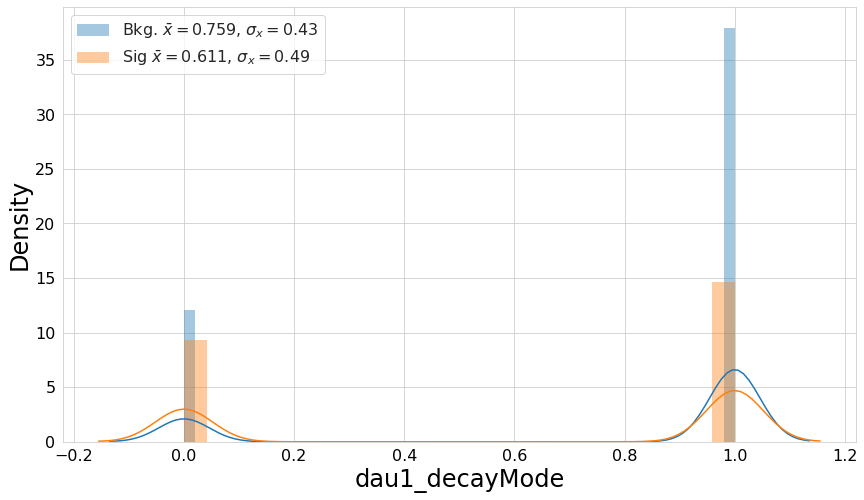

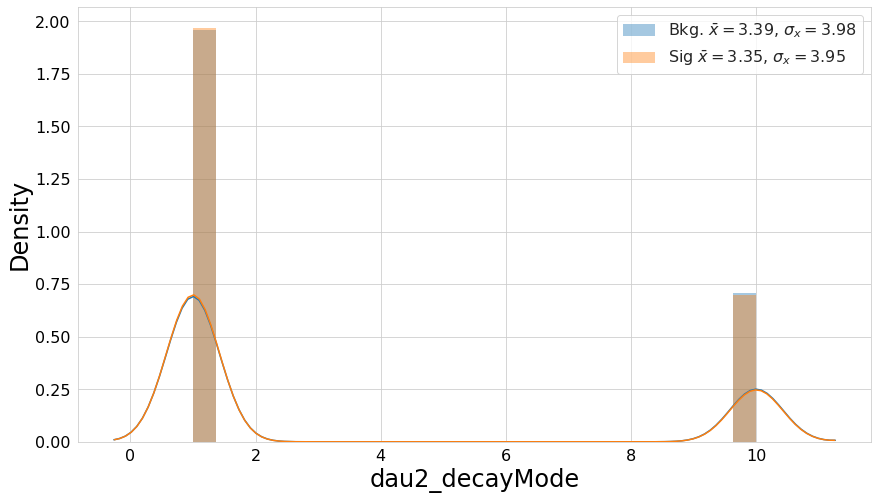

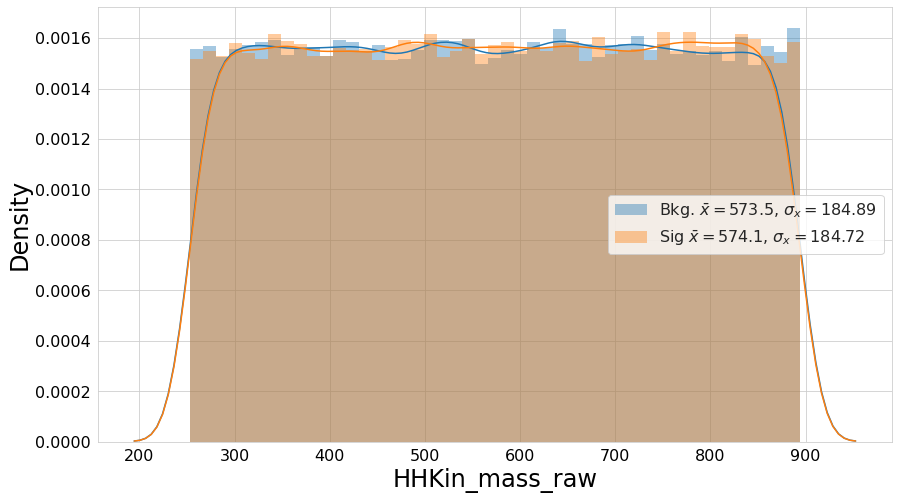

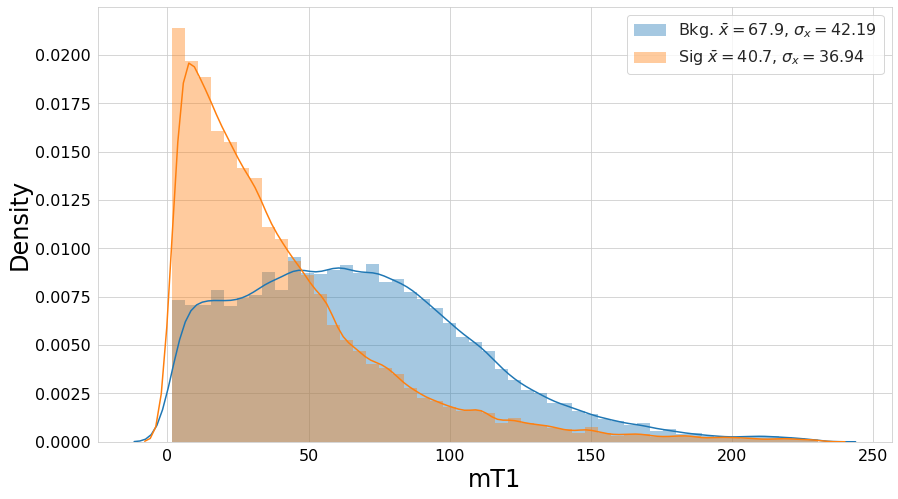

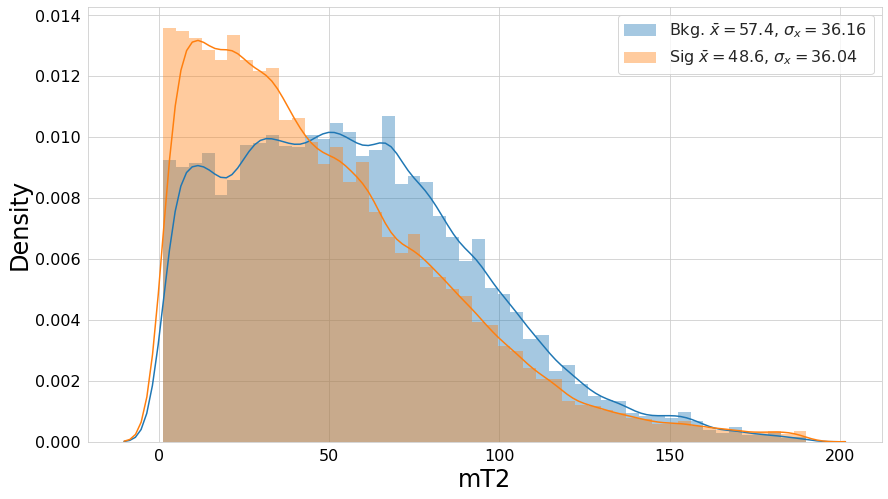

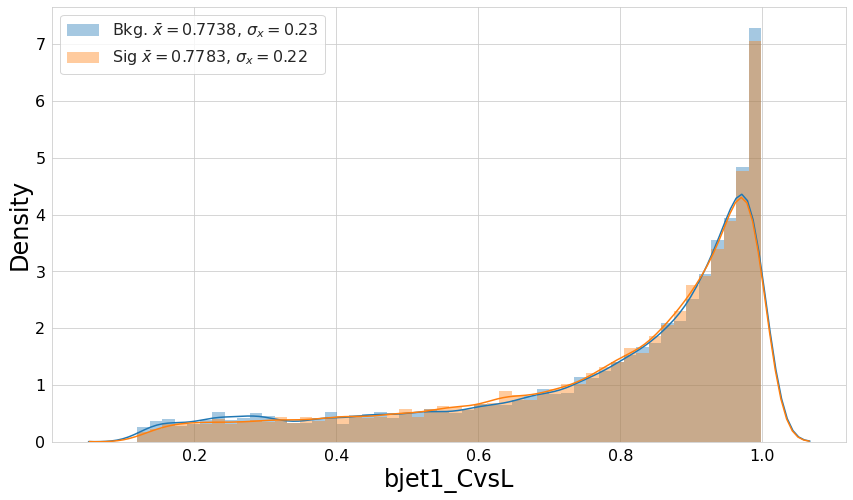

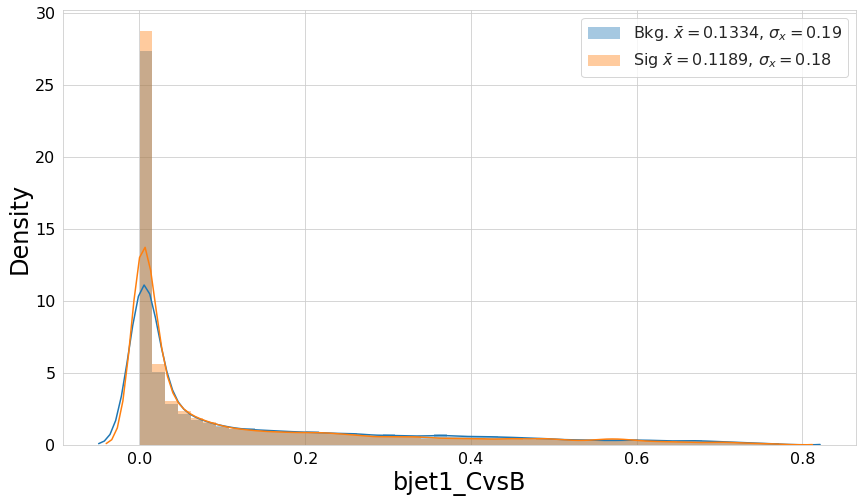

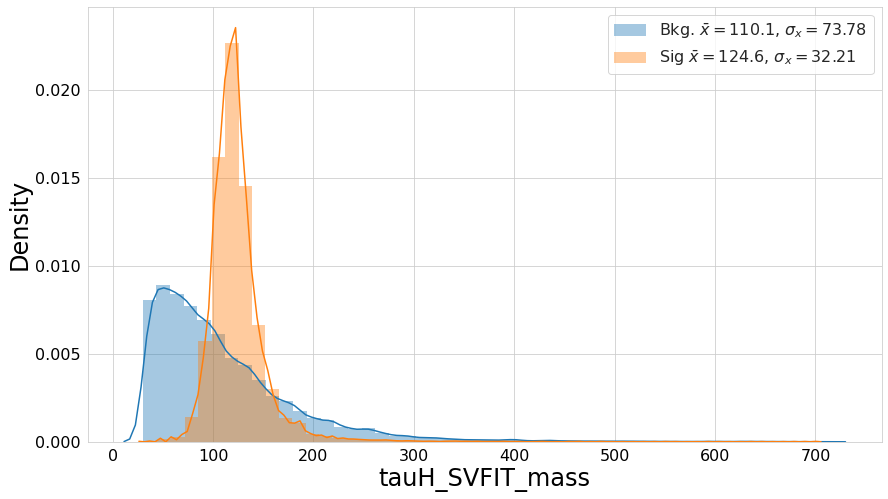

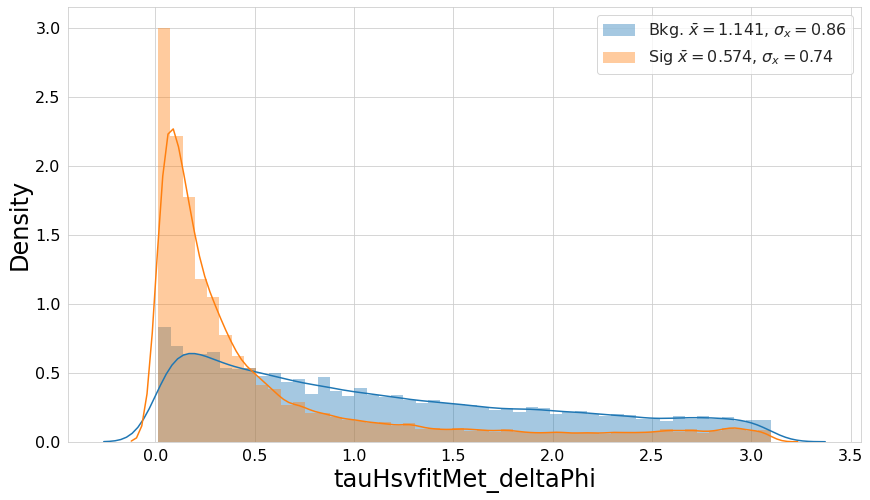

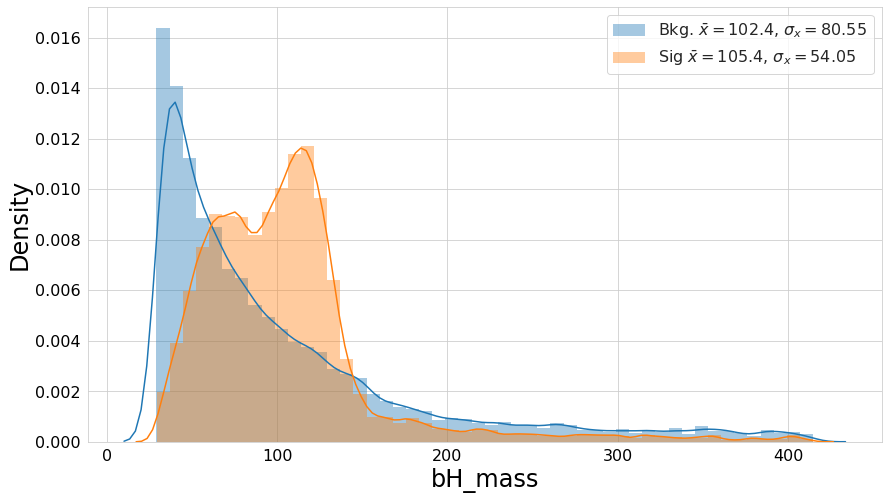

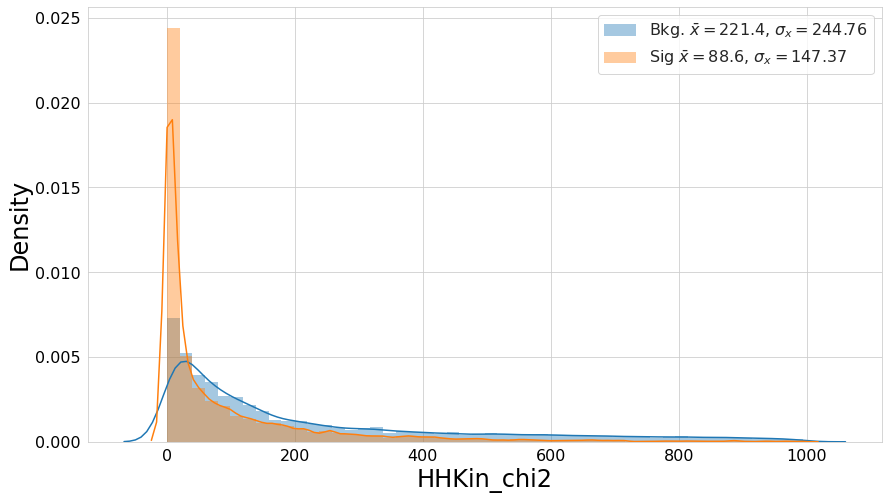

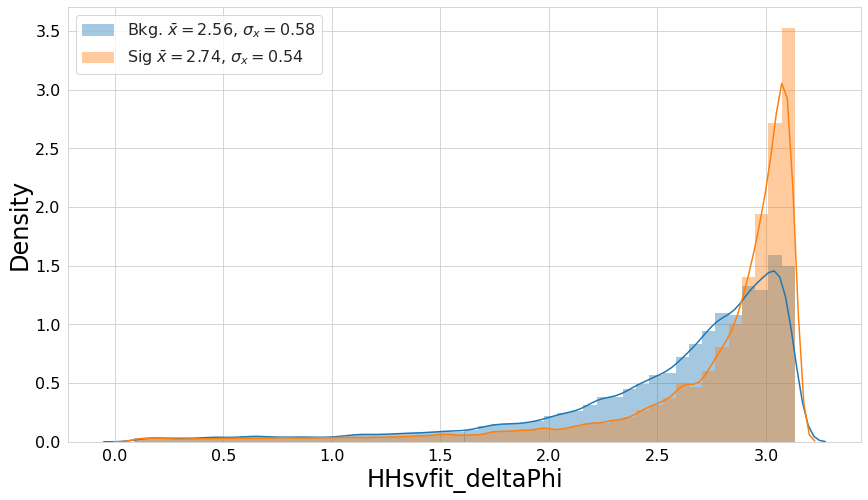

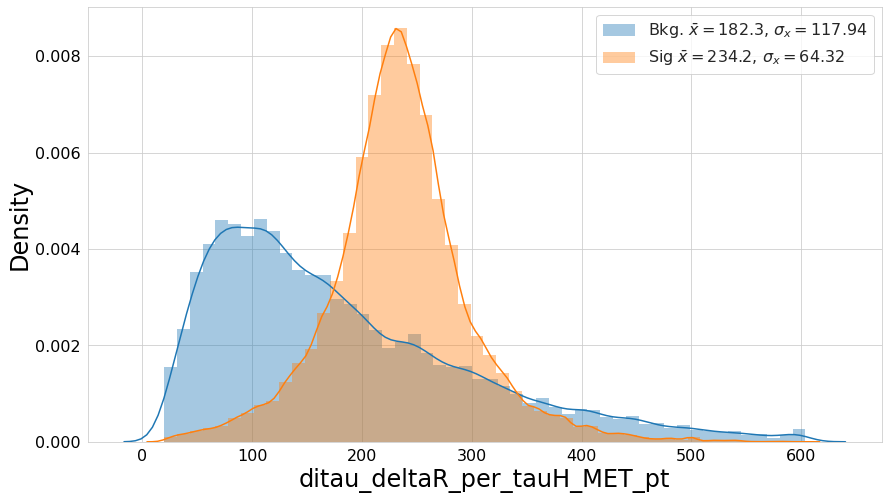

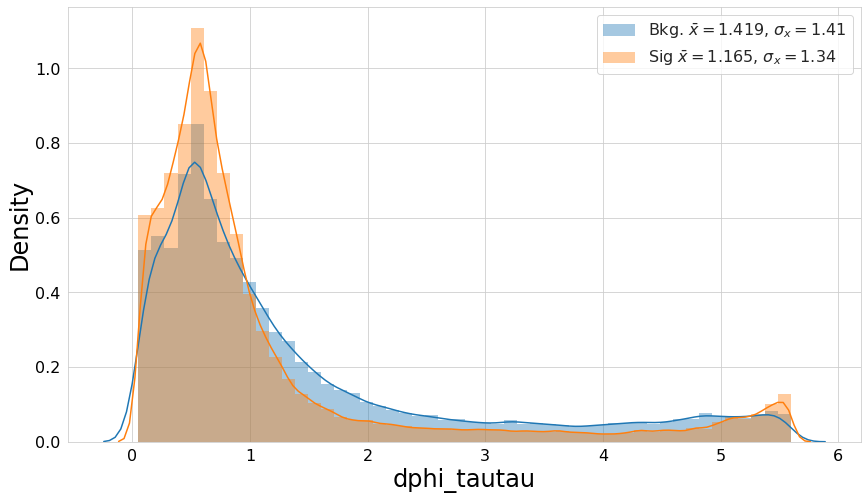

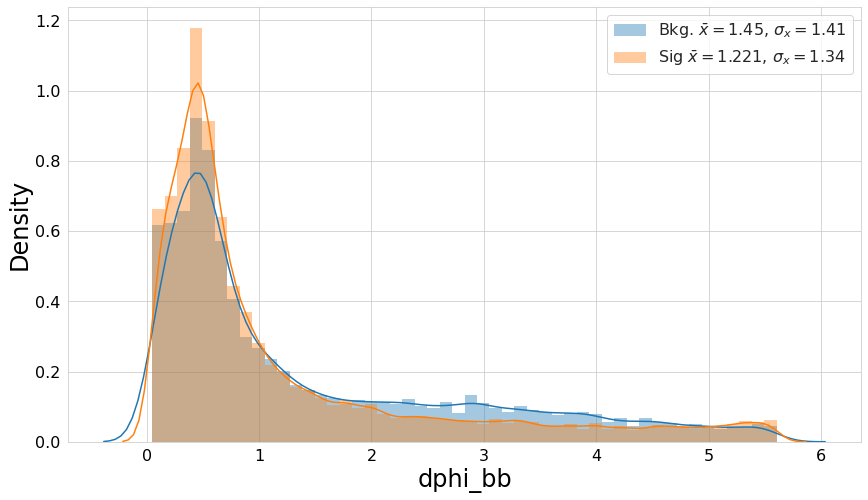

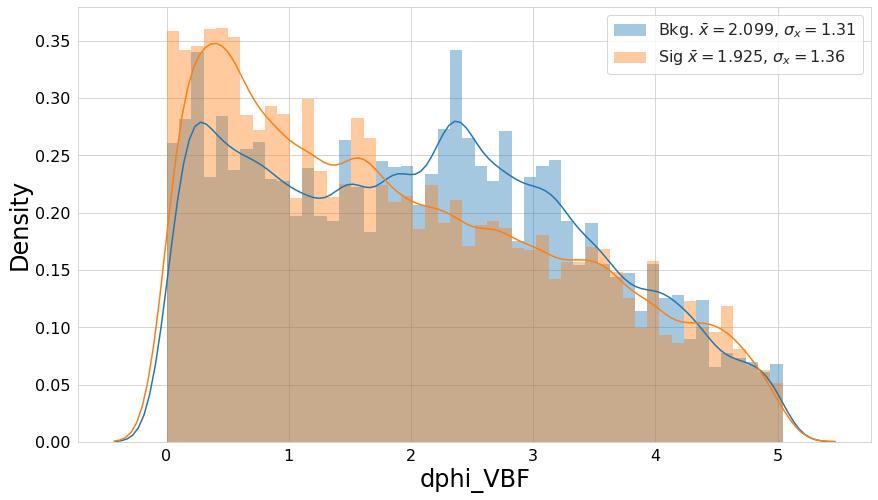

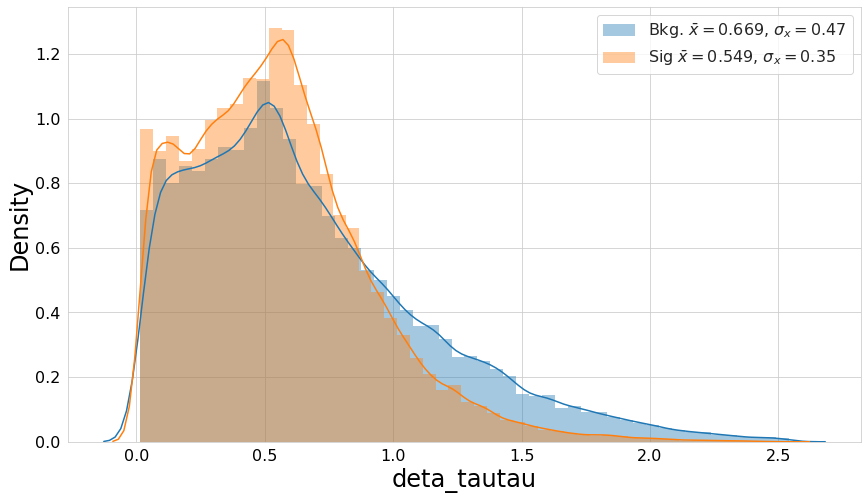

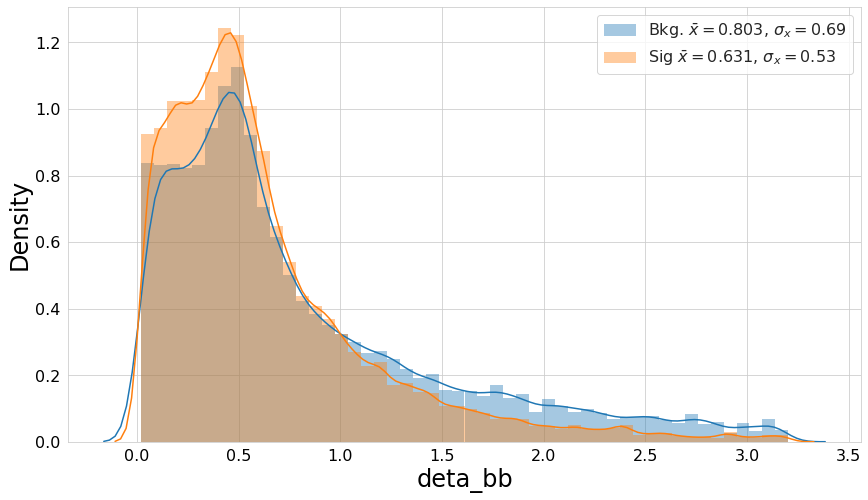

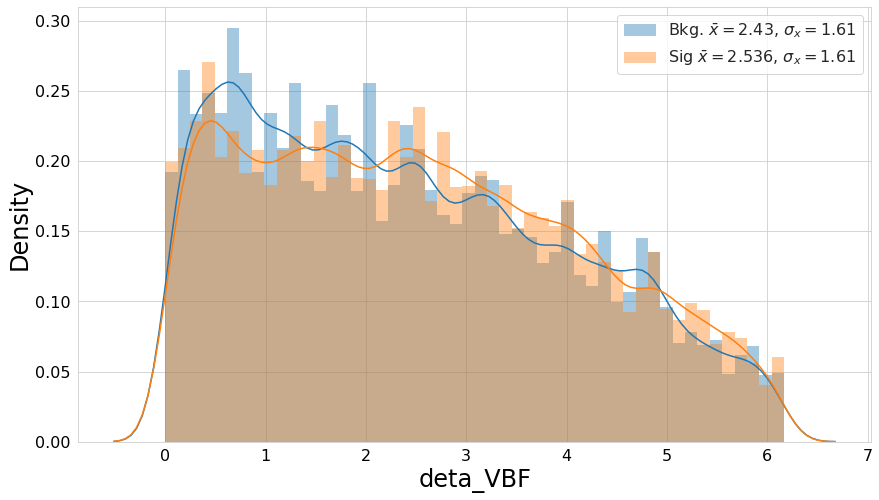

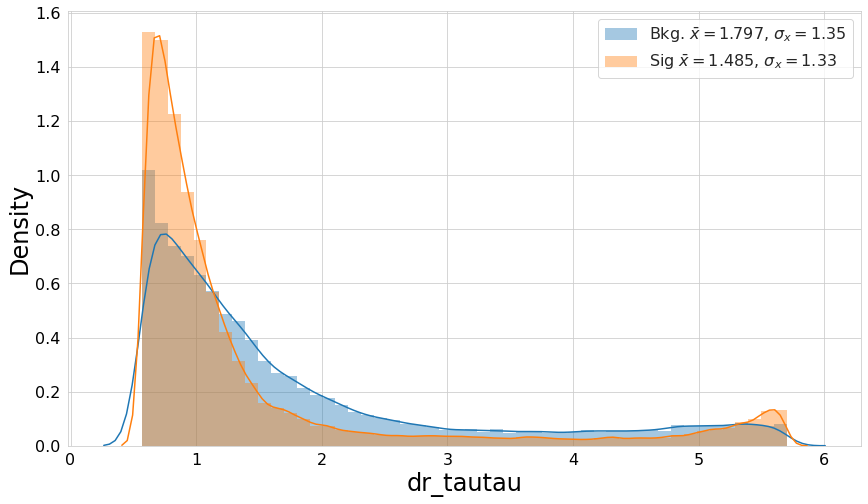

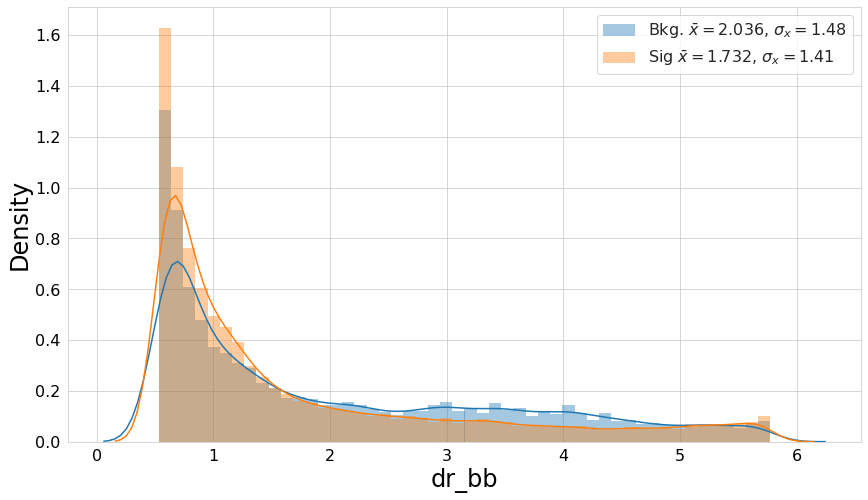

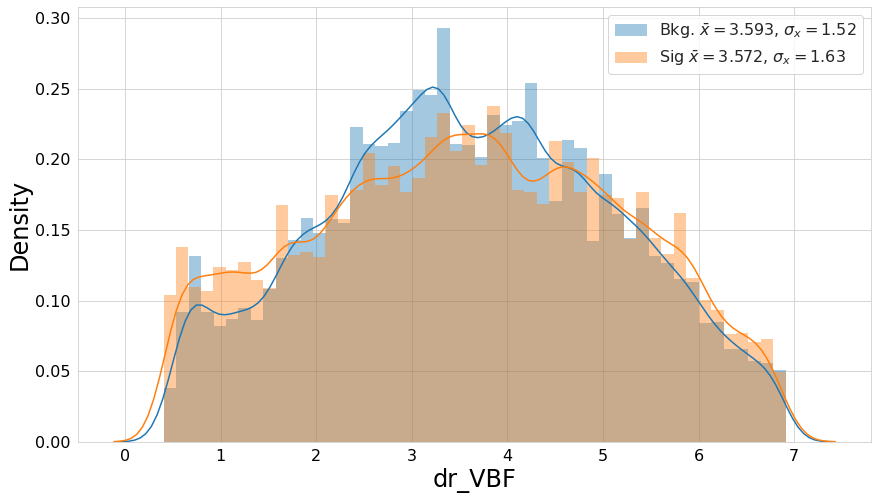

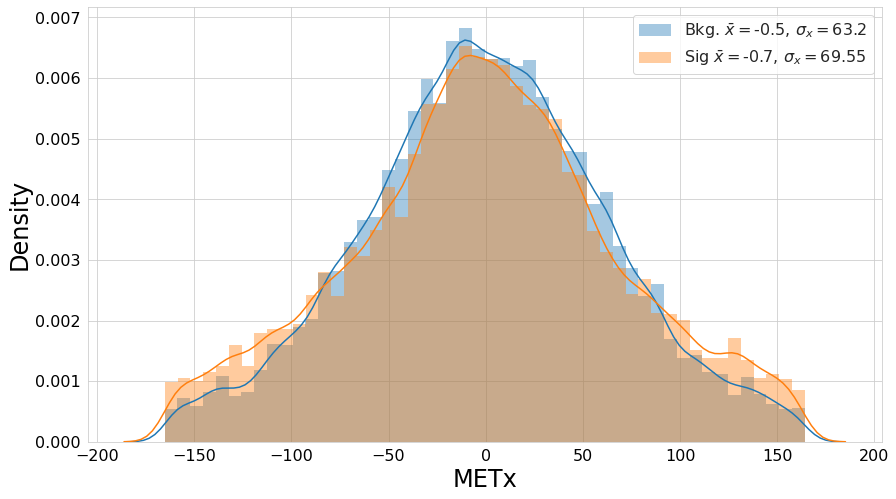

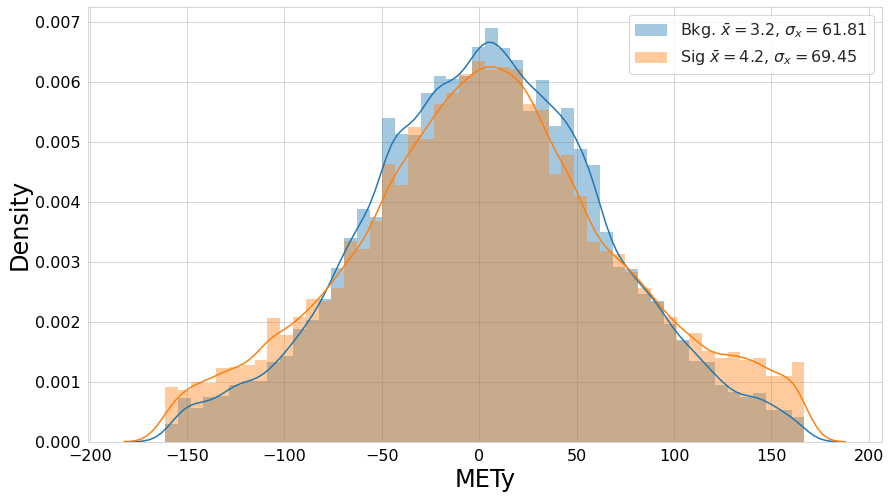

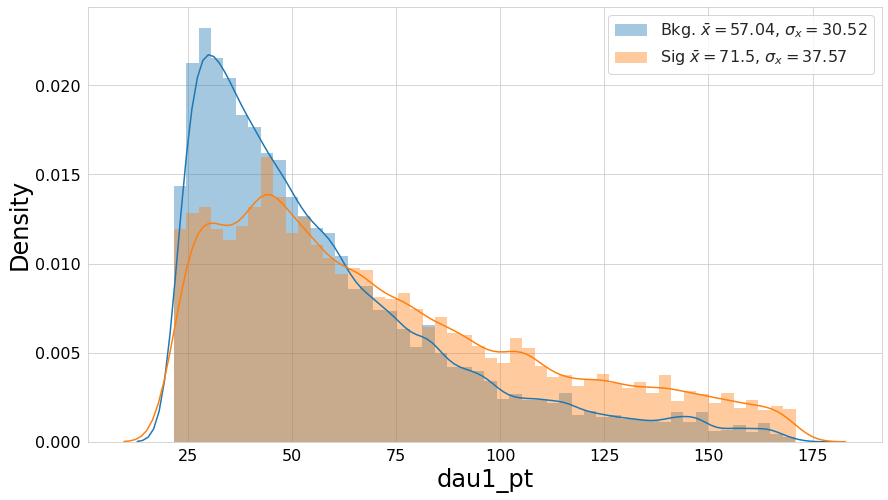

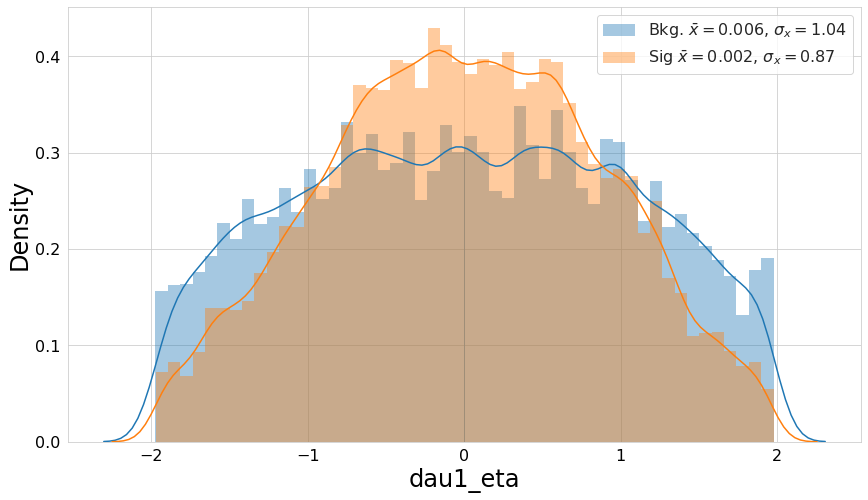

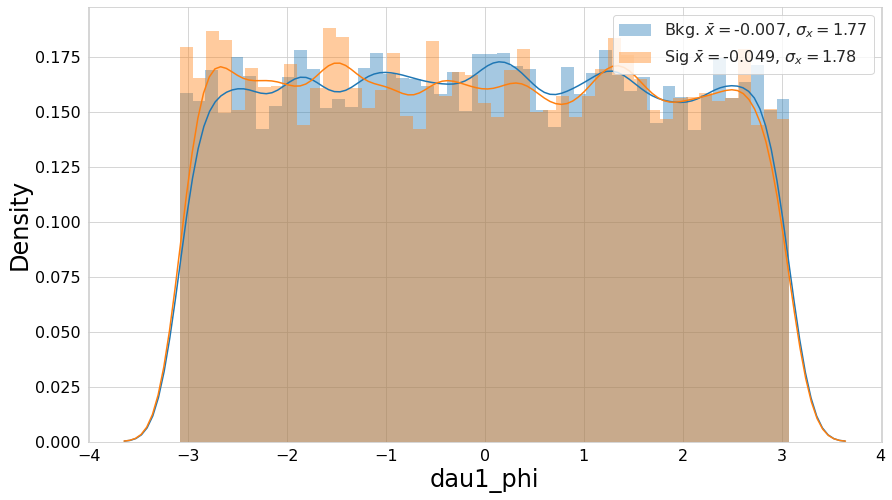

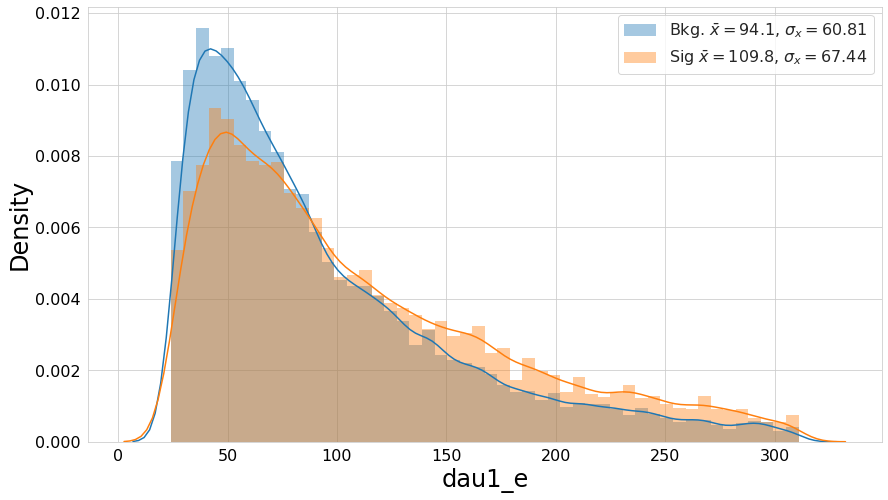

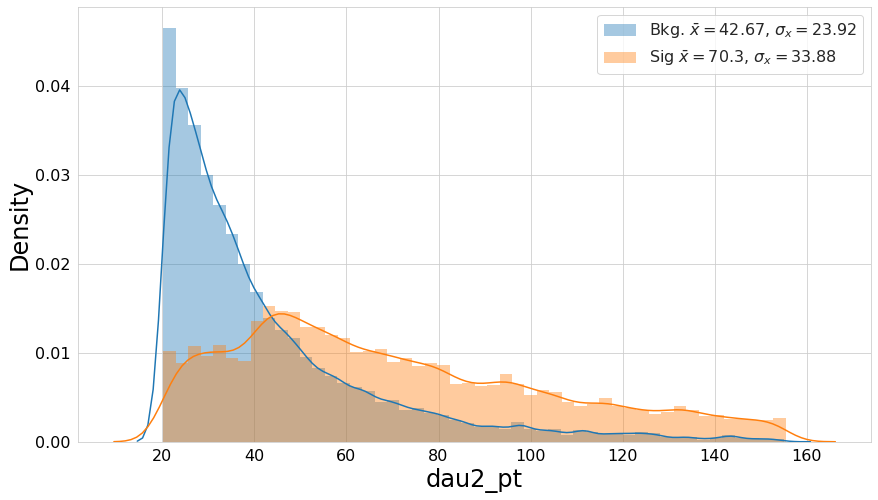

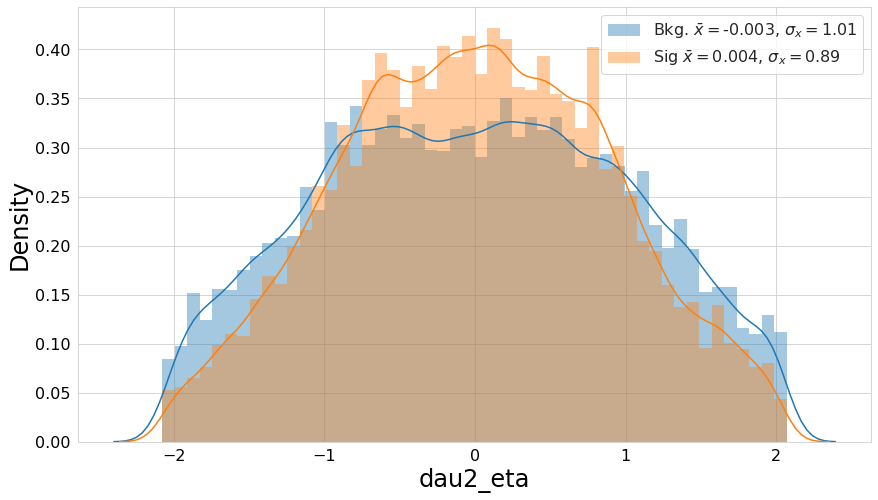

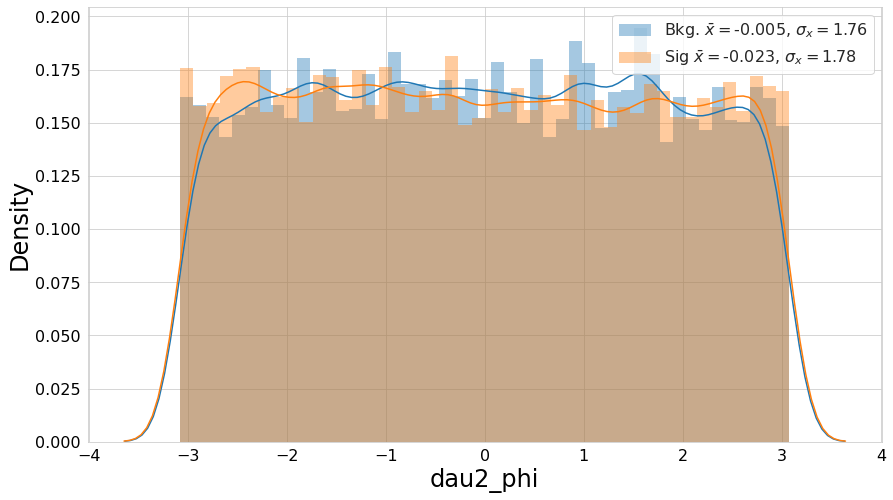

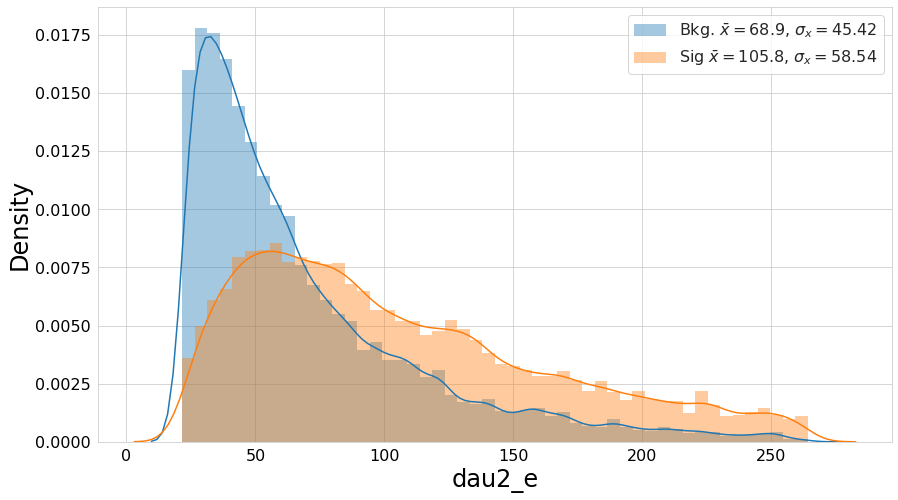

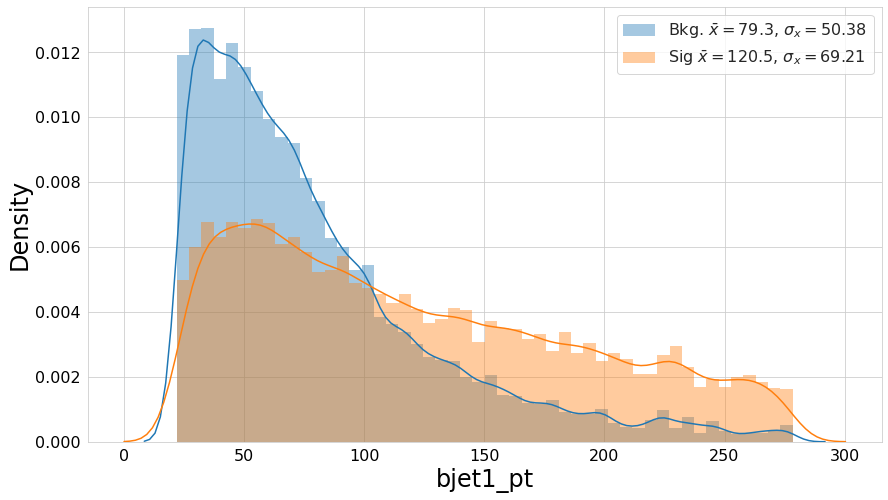

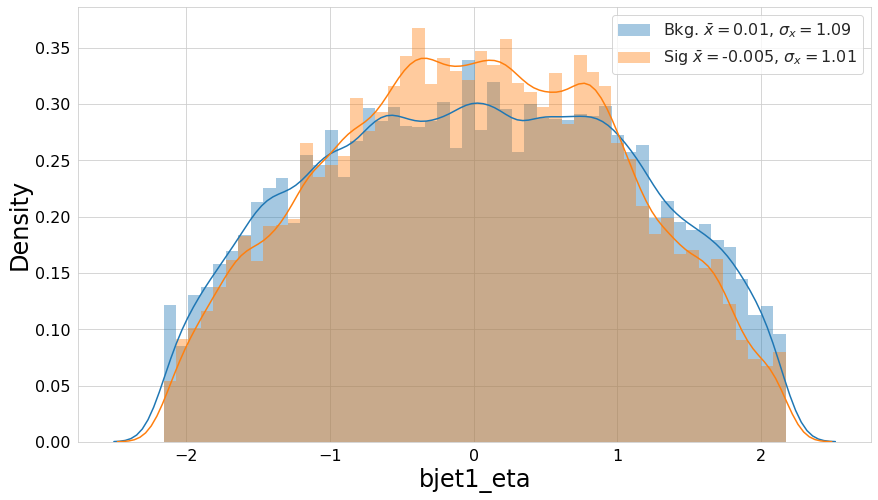

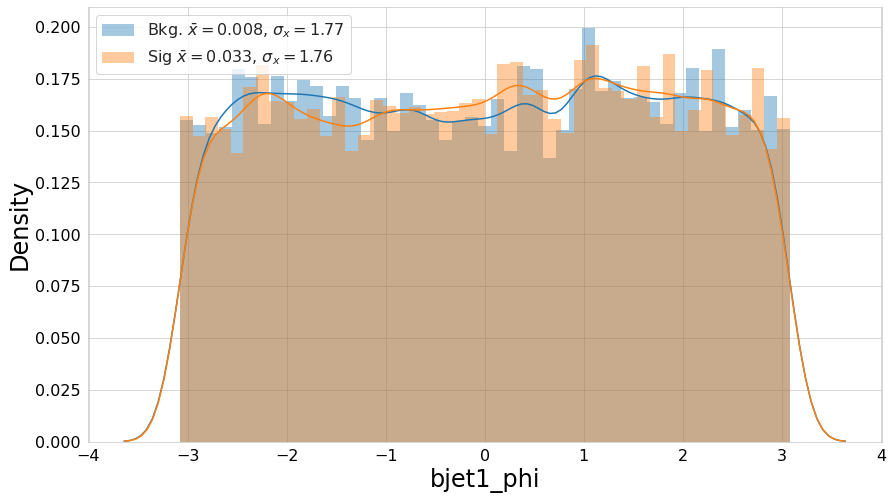

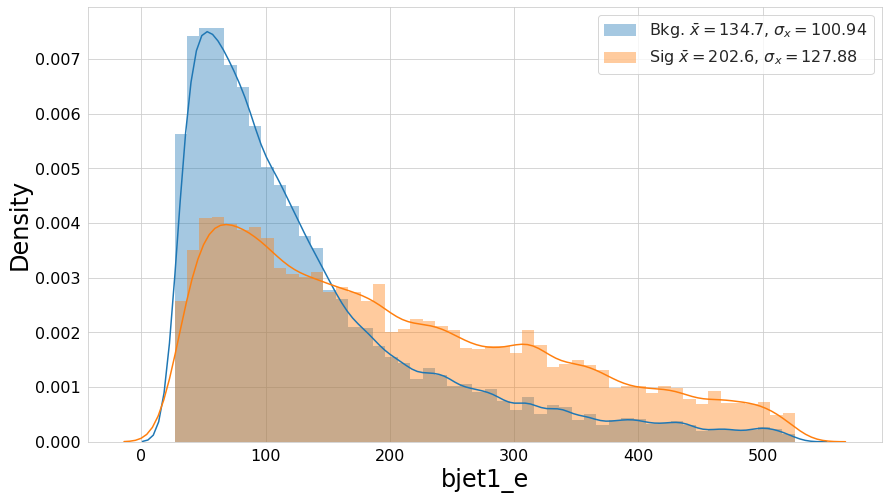

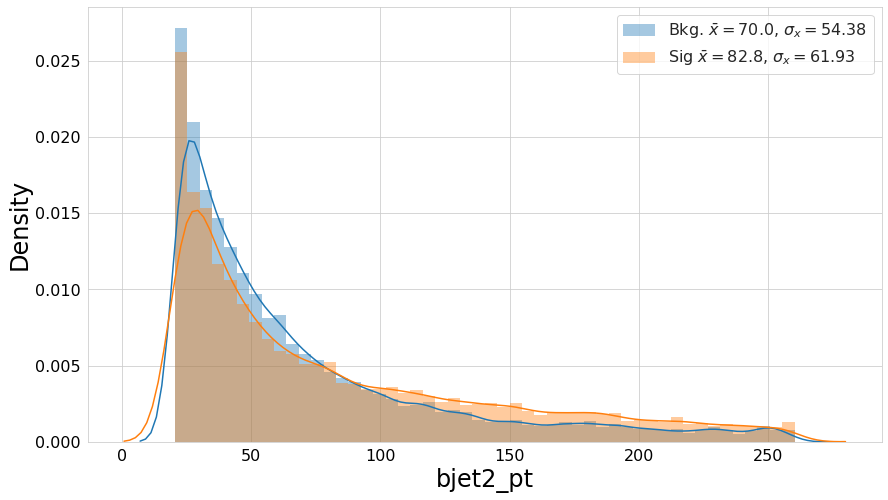

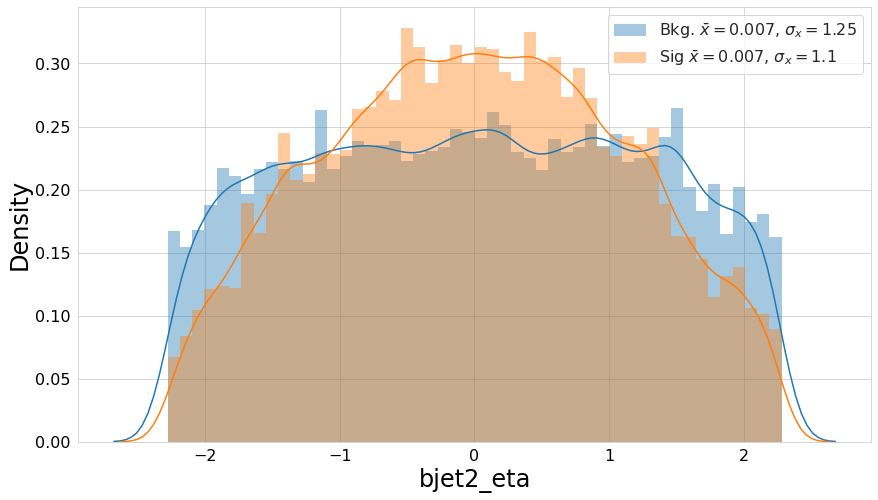

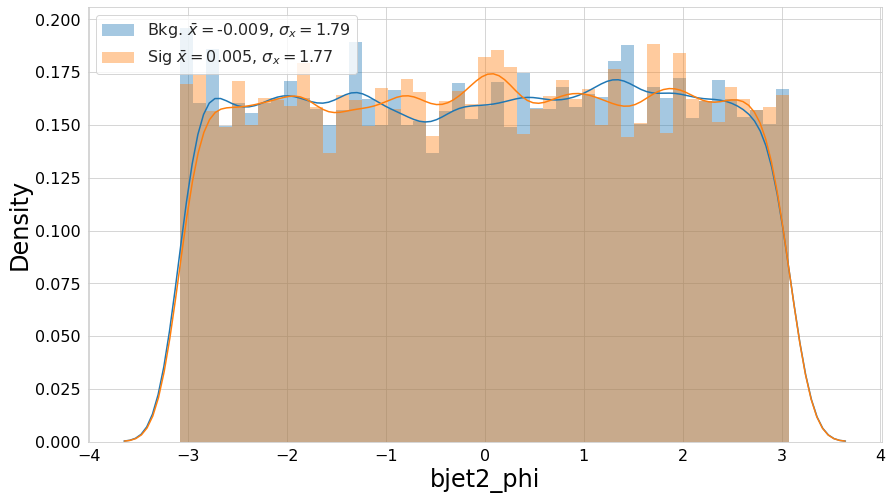

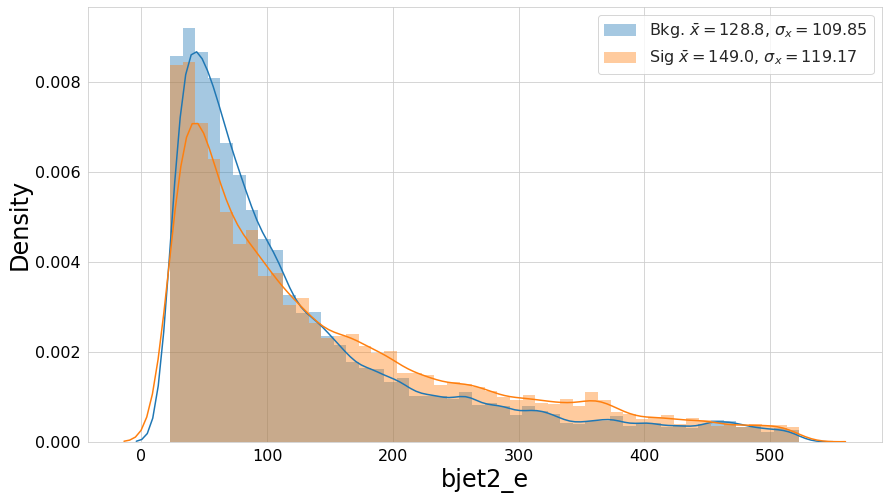

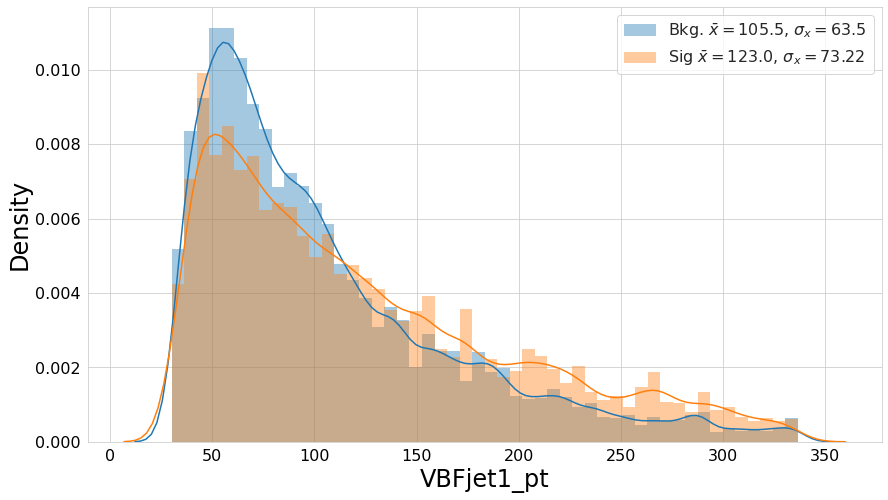

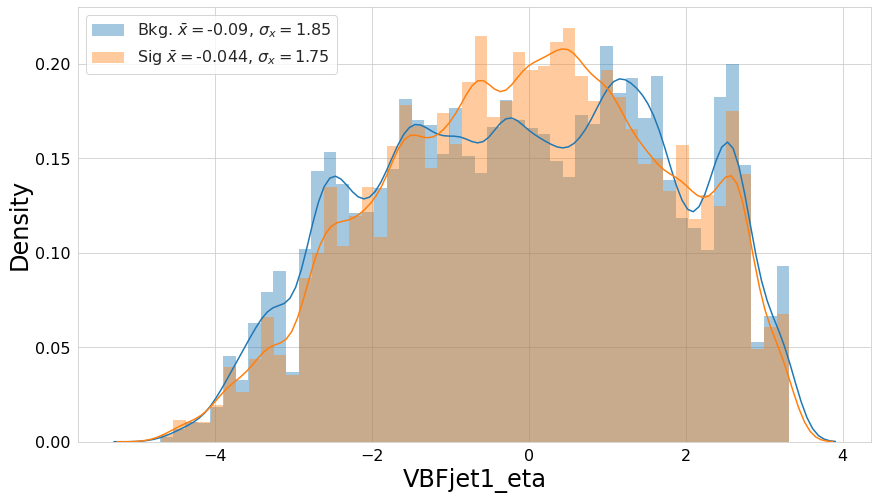

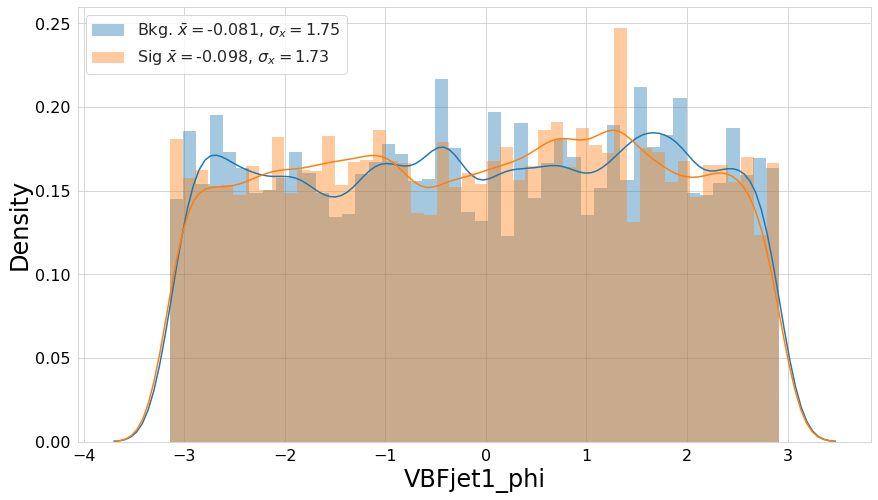

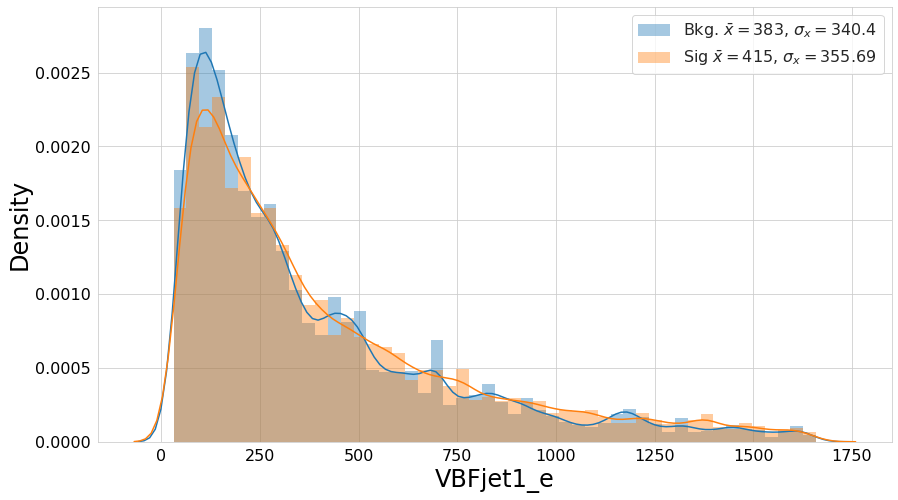

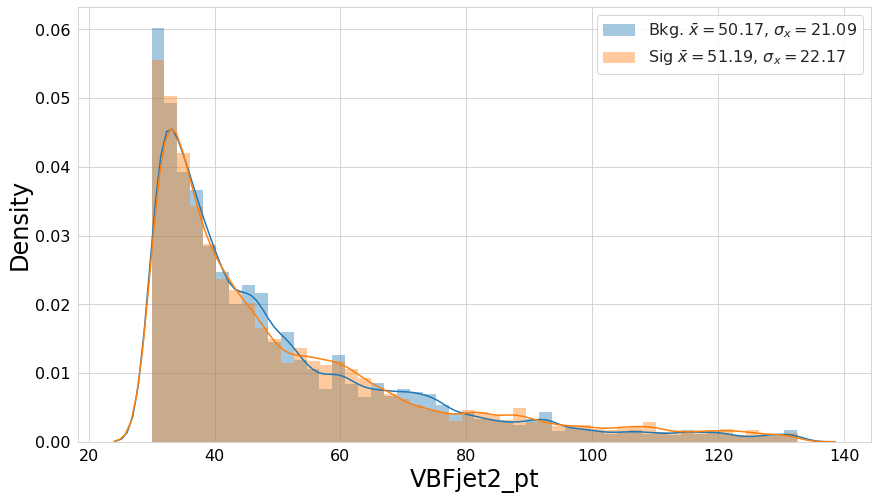

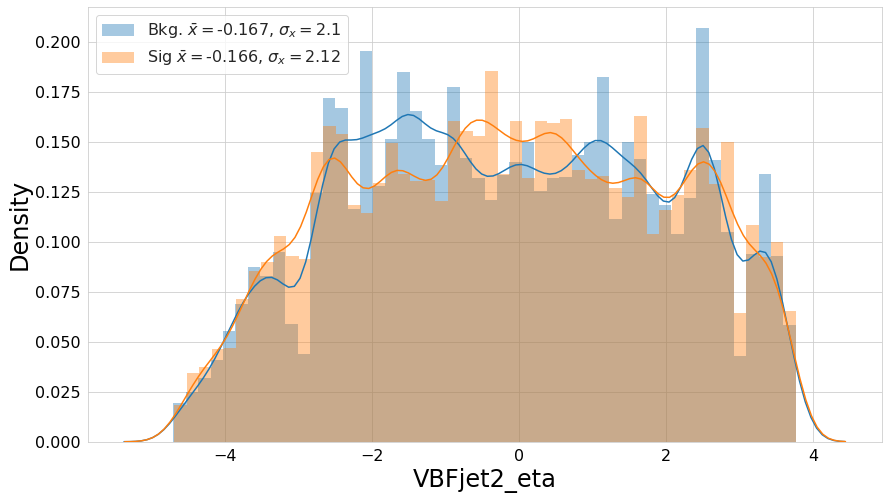

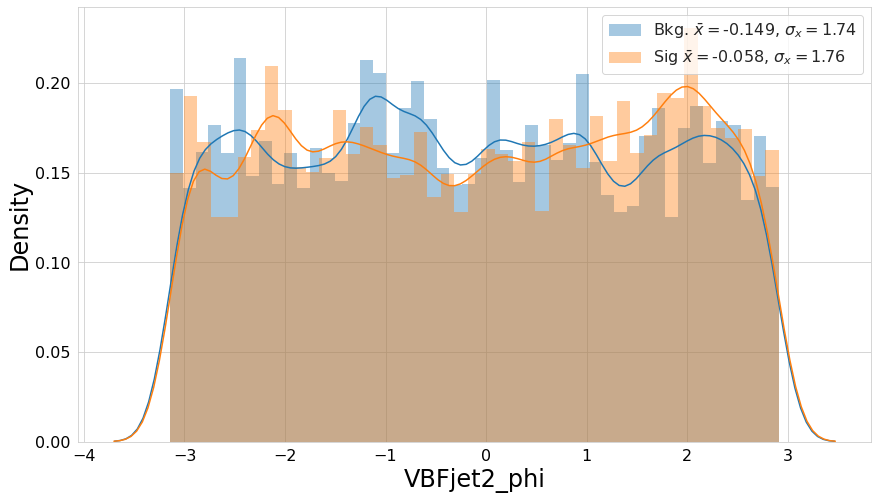

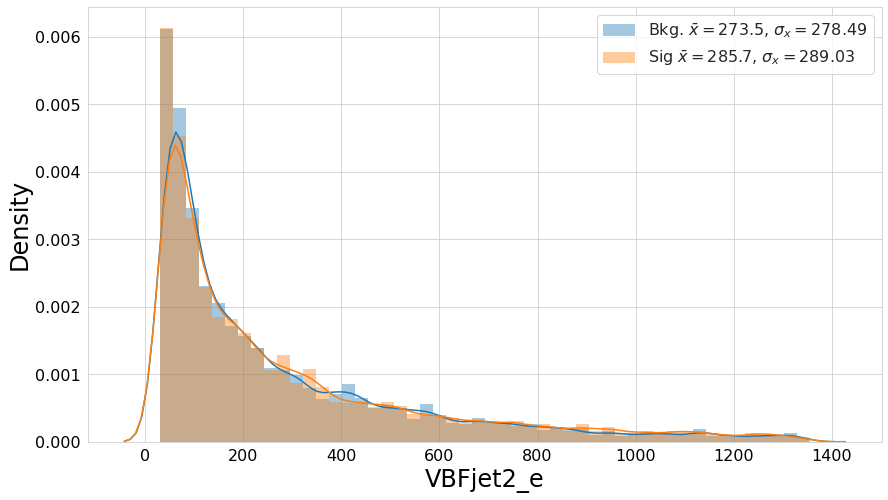

In [48]:
from lumin.plotting.data_viewing import plot_feat

for feature in train_feats:
#for feature in cont_feats:
#for feature in cat_feats:
    plot_feat(Events, feature, cuts=[(Events.Class==0),(Events.Class==1)], labels=['Bkg.','Sig'], wgt_name='w_planing')

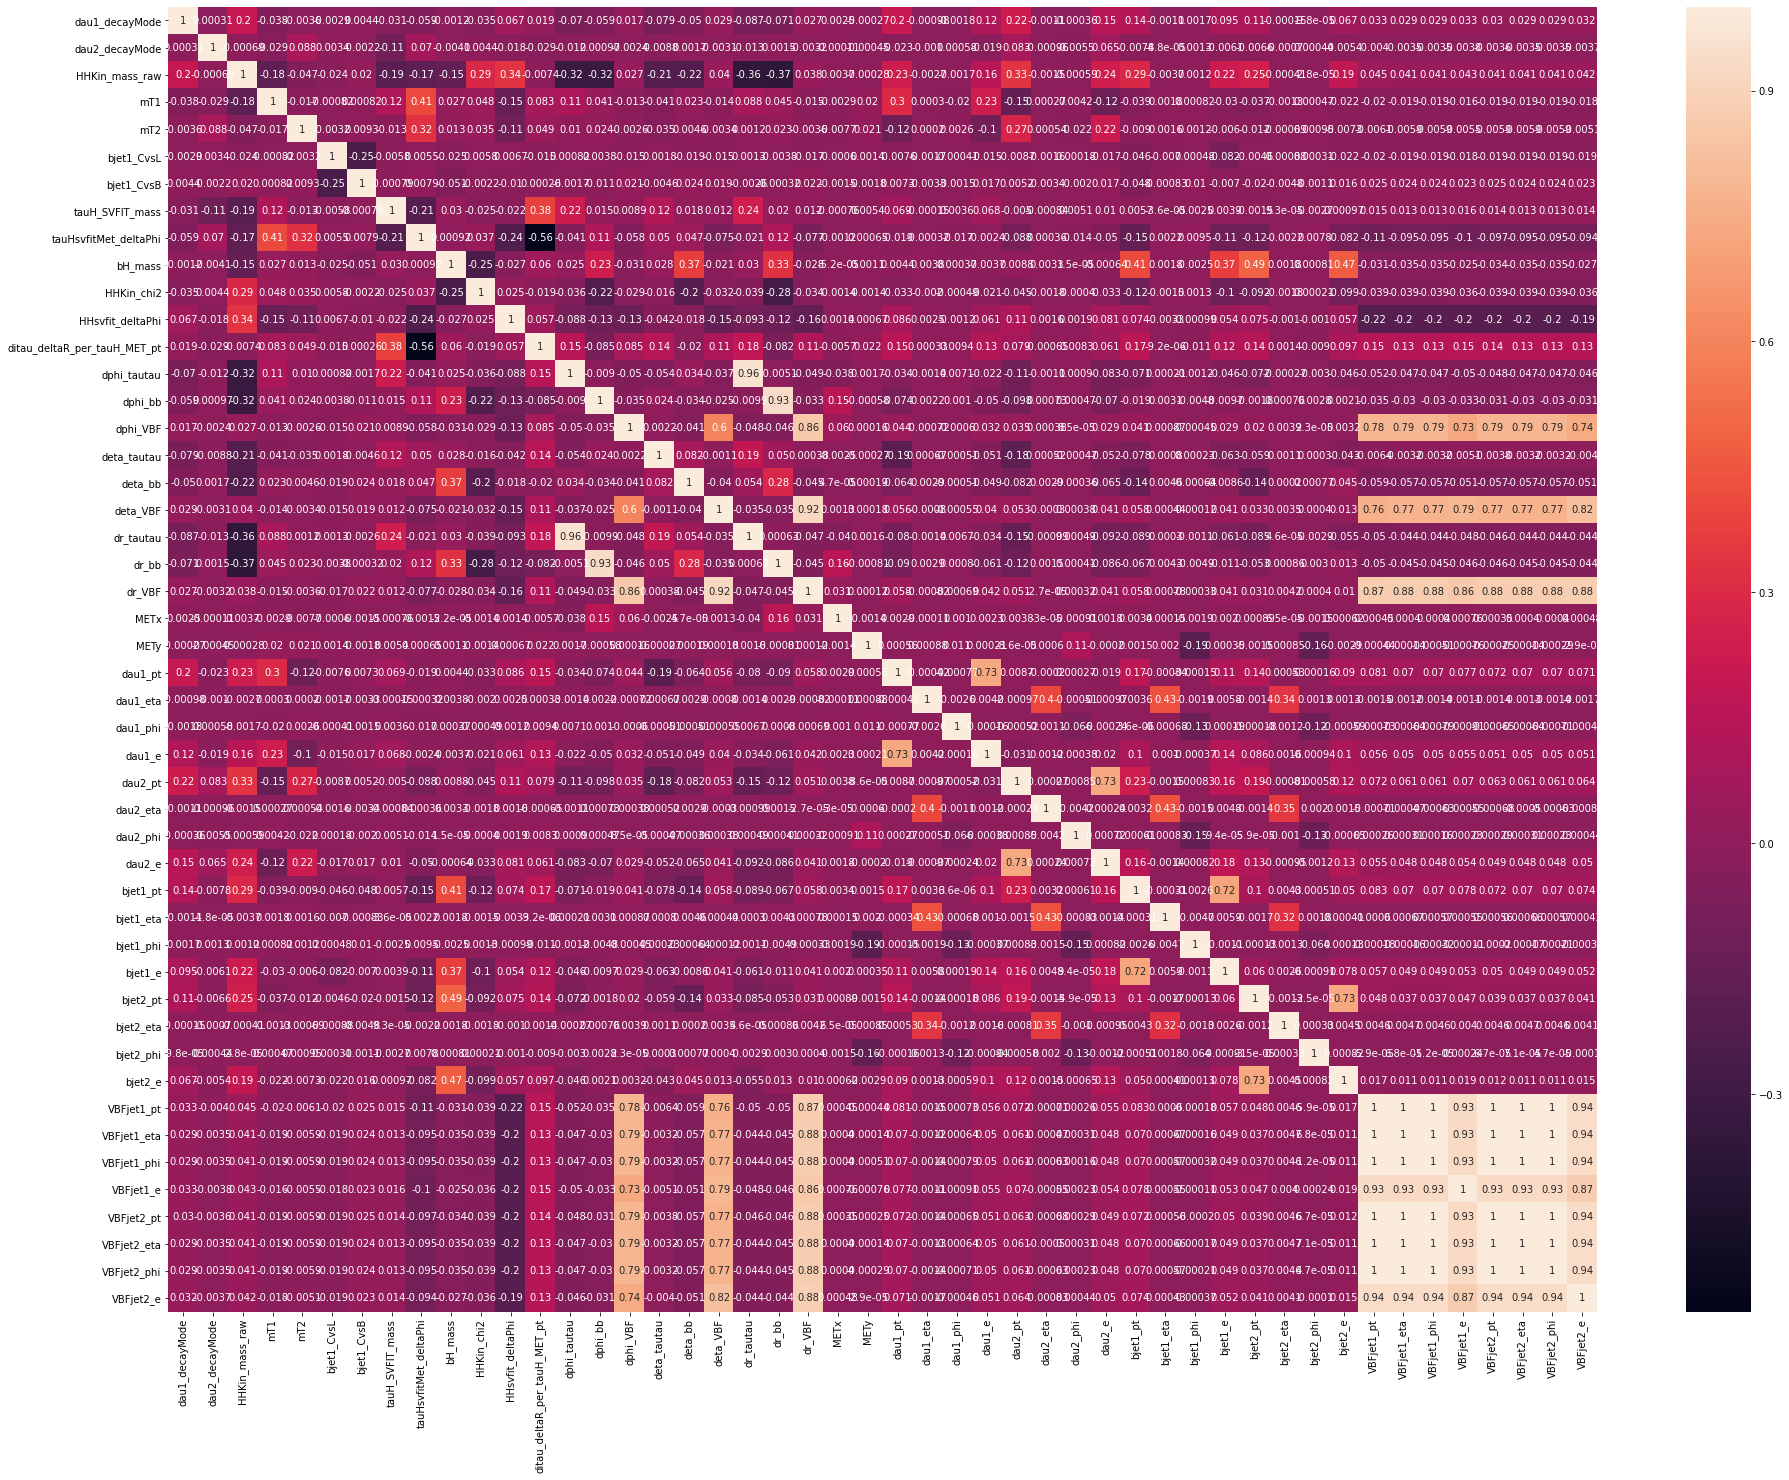

In [50]:
plt.figure(figsize=(32, 24))
import seaborn as sns
corr_sig = Events[train_feats].corr()
sns.heatmap(corr_sig, annot=True, xticklabels=train_feats, yticklabels=train_feats)
plt.show()

###  Train/test splitting

In [51]:
from sklearn.model_selection import train_test_split 
Events_train, Events_test = train_test_split(Events, test_size=0.2, stratify=Events.Class, random_state=42)

from lumin.utils.data import check_val_set
check_val_set(Events_train[train_feats], Events_test[train_feats])

from lumin.data_processing.pre_proc import fit_input_pipe
input_pipe = fit_input_pipe(Events_train, cont_feats, '/data_CMS/cms/portales/HHresonant_DANNlumin/input_pipe')

Events_train[cont_feats] = input_pipe.transform(Events_train[cont_feats])
Events_test[cont_feats] = input_pipe.transform(Events_test[cont_feats])


AUC for train-validation discrimination = 0.5004673359347979
Top 10 most important features are:
   index      Feature  Importance
0      0     dau2_eta    0.007011
1      1    bjet1_phi    0.005884
2      2   bjet1_CvsB    0.005258
3      3  dphi_tautau    0.005258
4      4    bjet2_phi    0.004757
5      5         METy    0.004507
6      6       dau1_e    0.004006
7      7          mT2    0.003380
8      8      dphi_bb    0.002879
9      9      bjet2_e    0.002629


### Post-processessing features drawing 

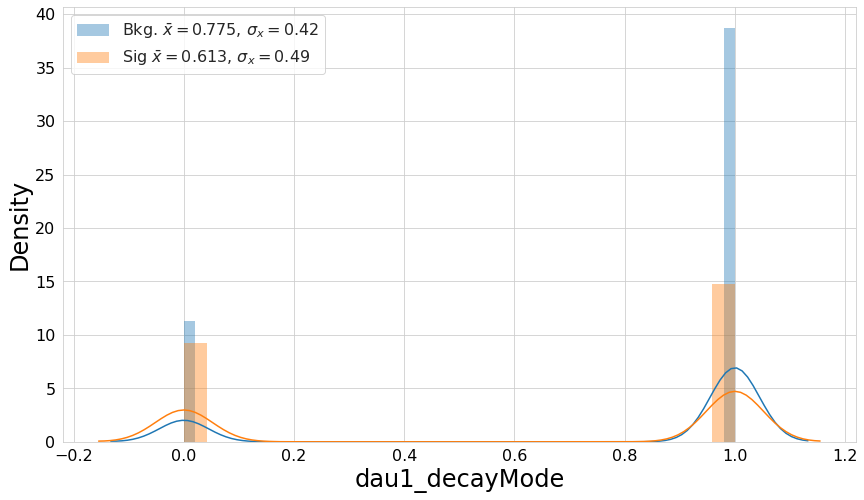

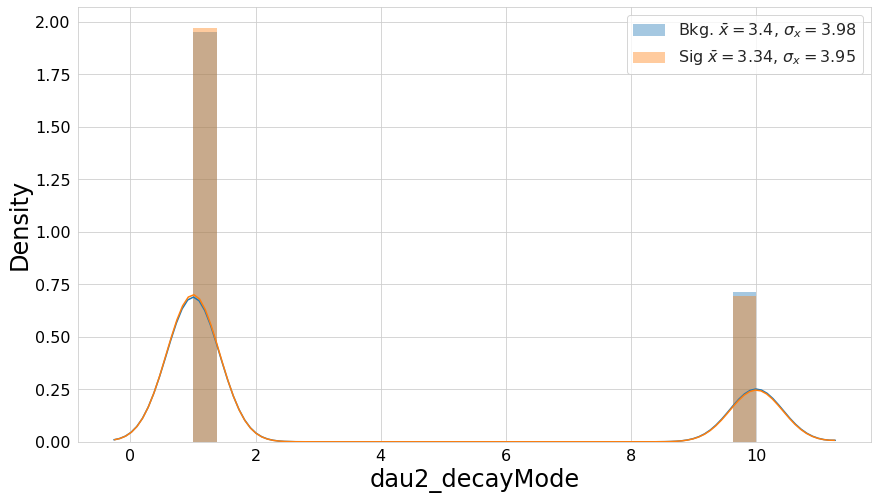

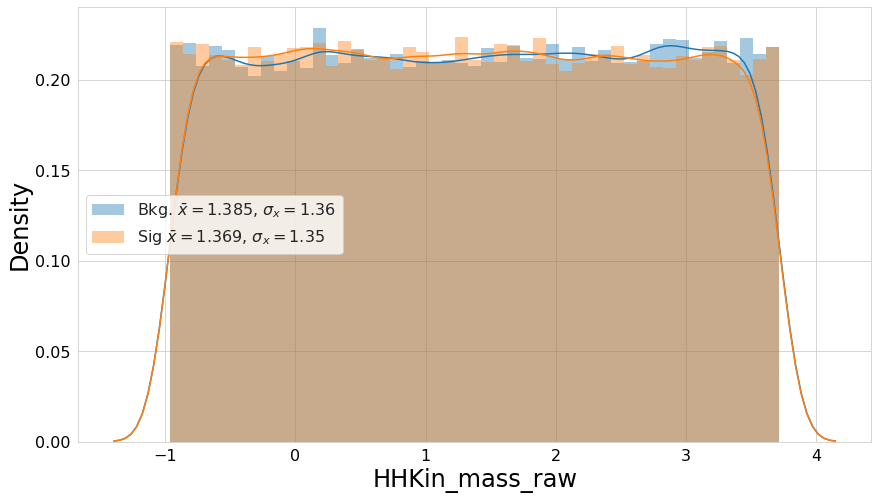

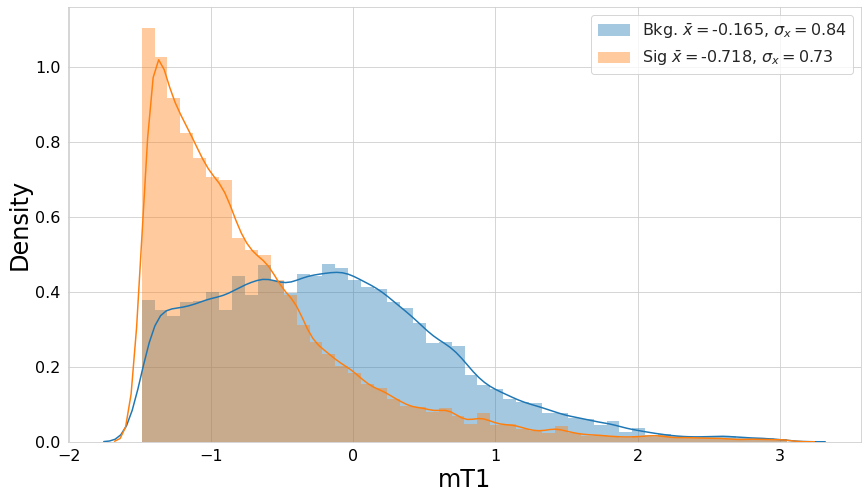

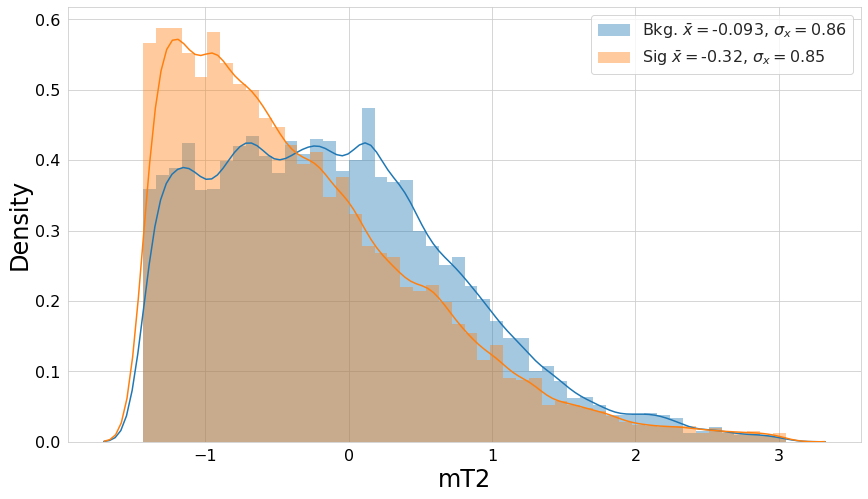

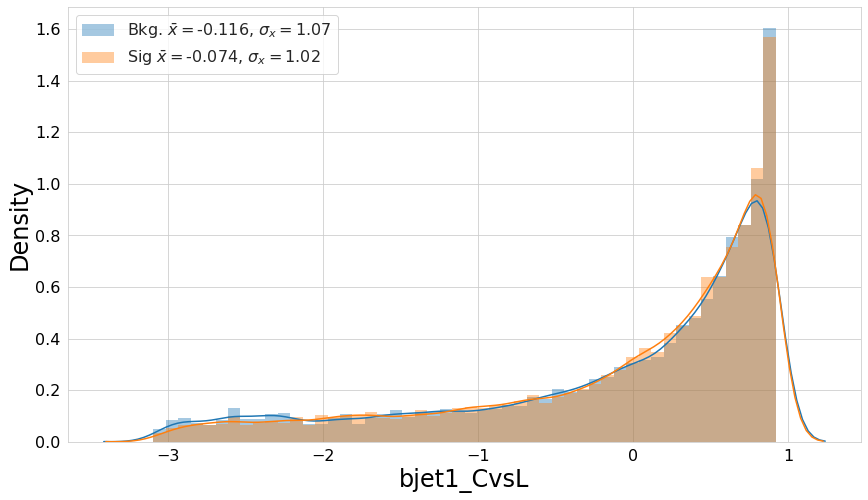

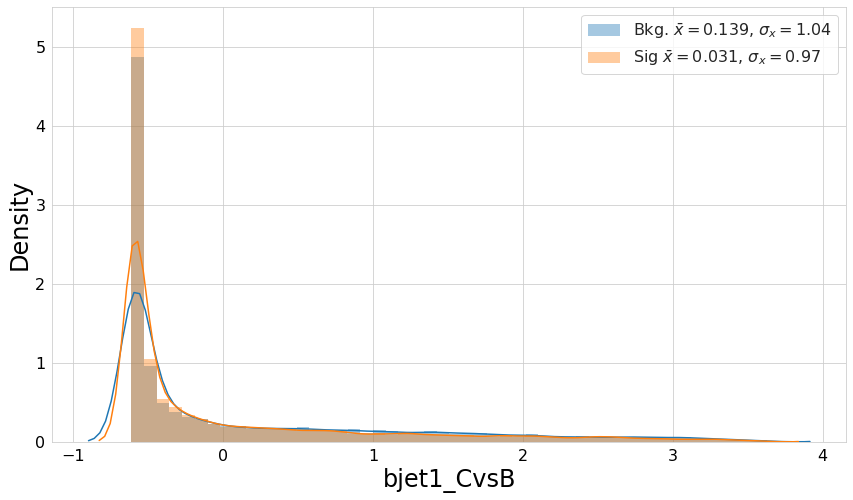

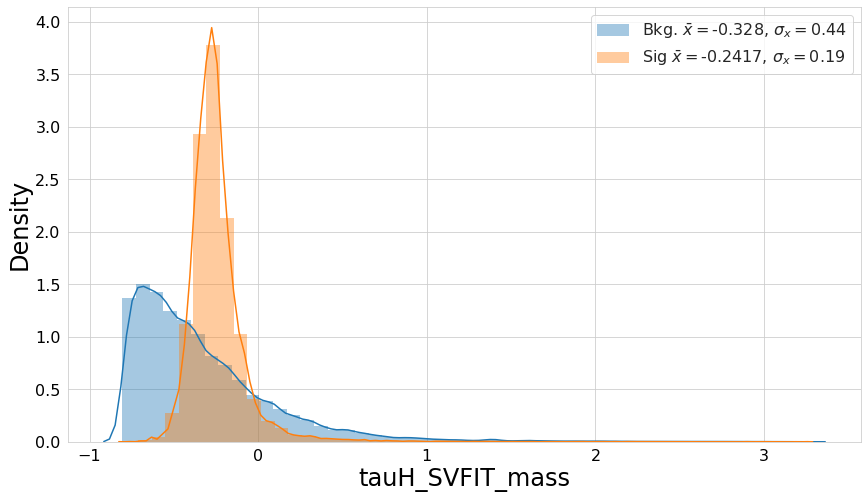

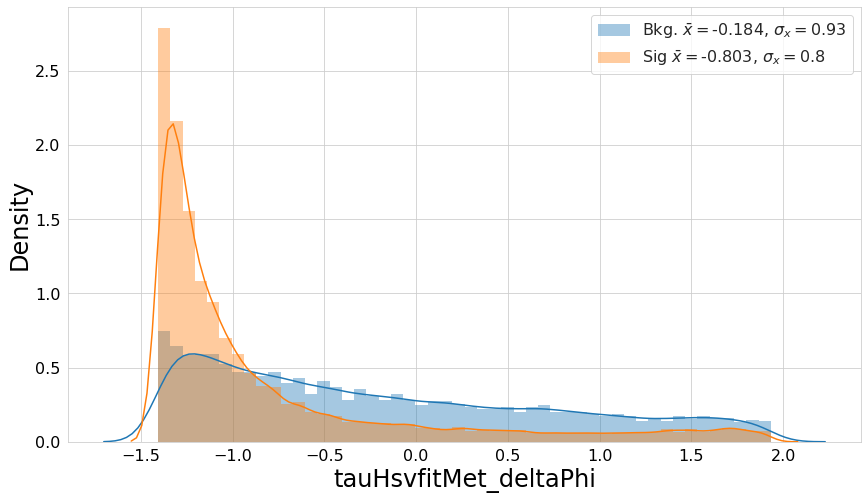

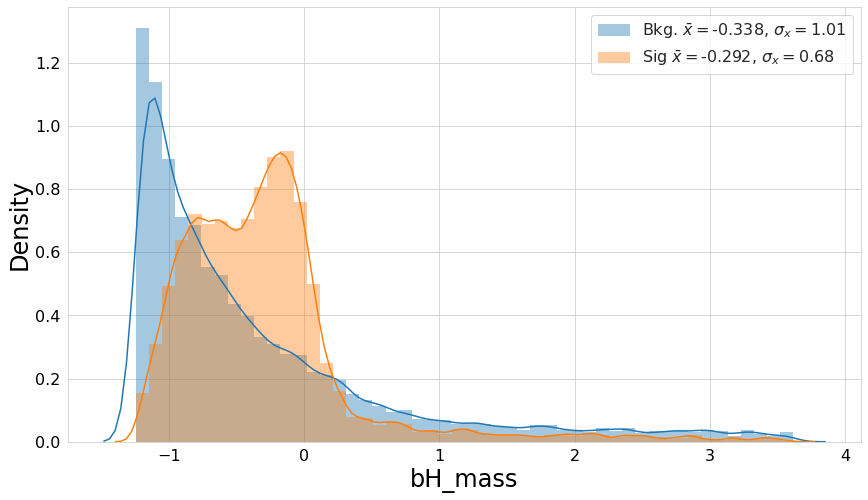

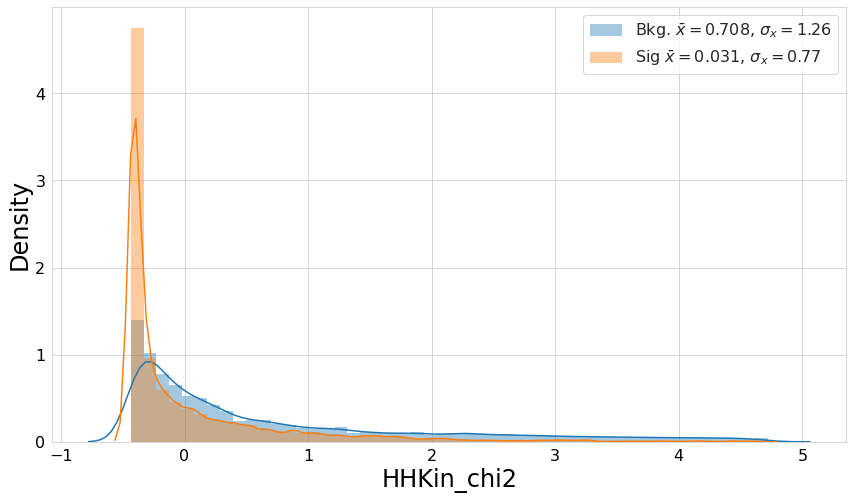

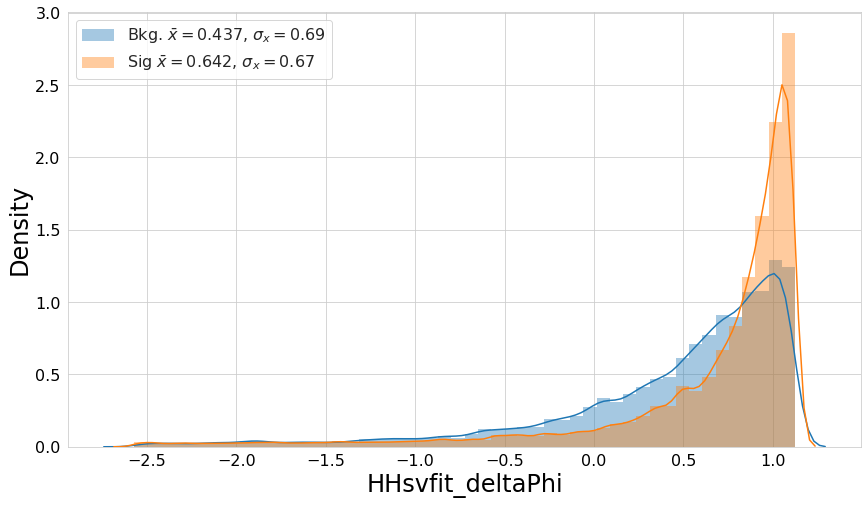

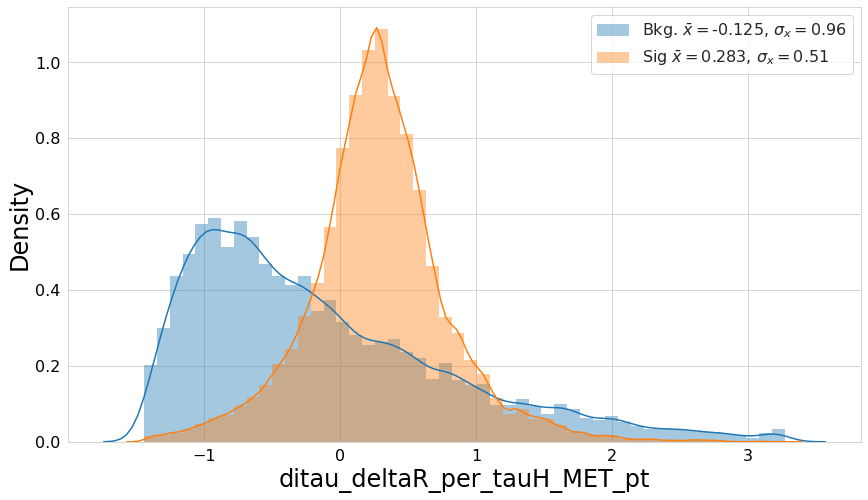

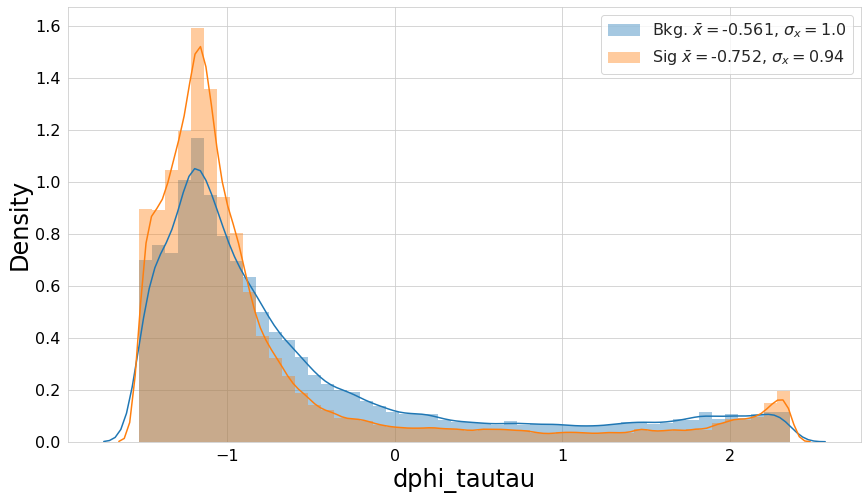

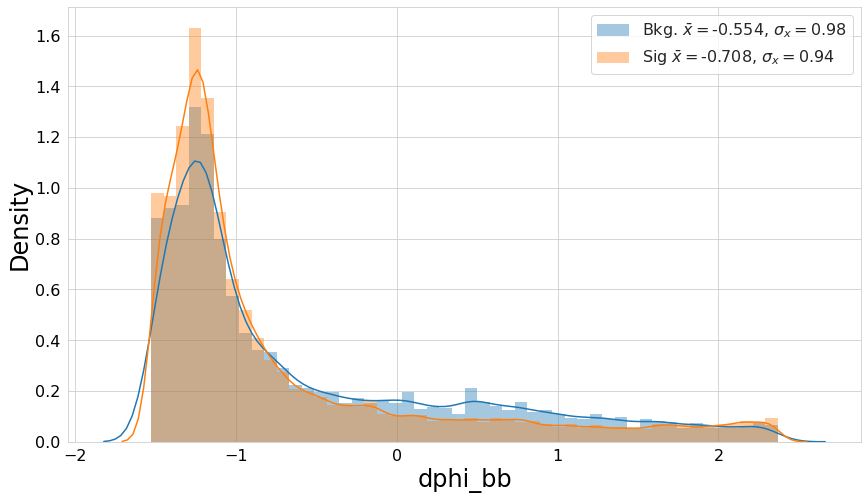

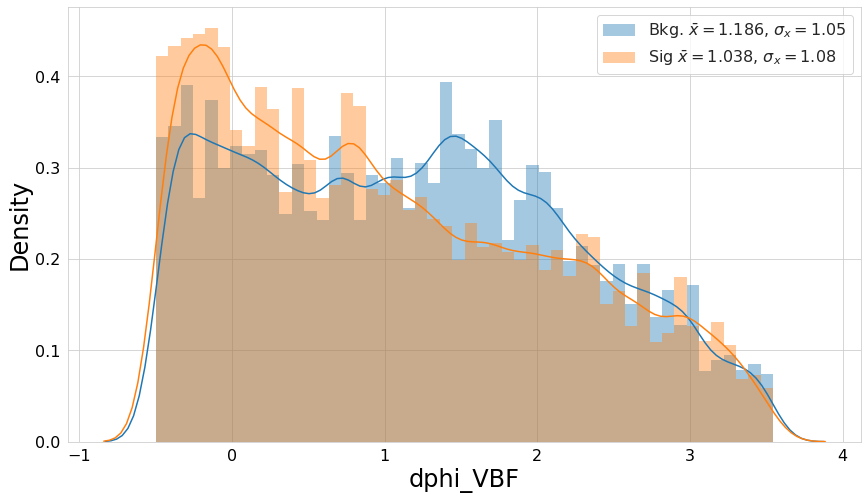

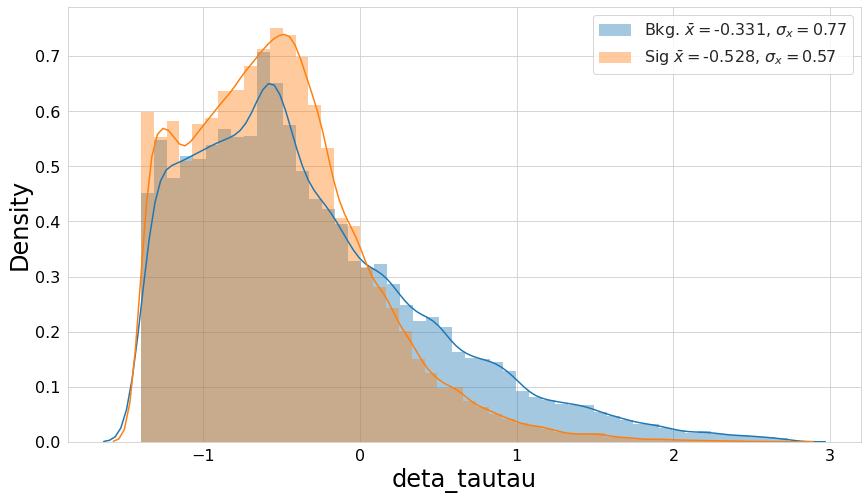

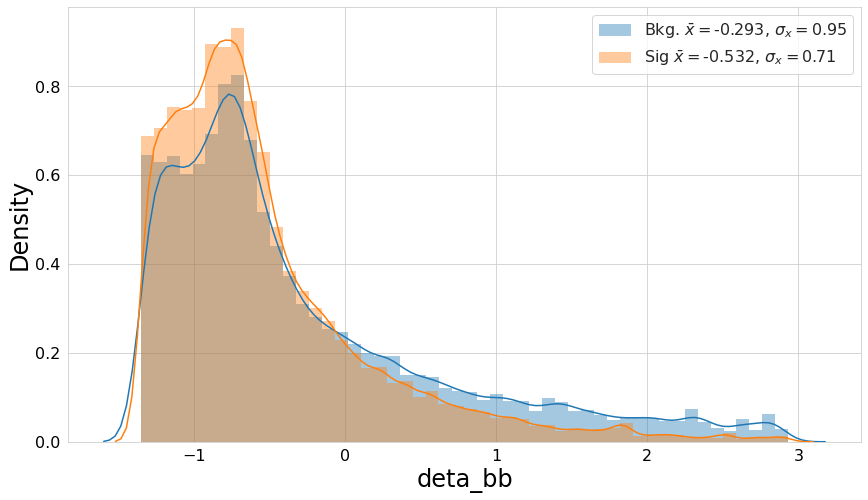

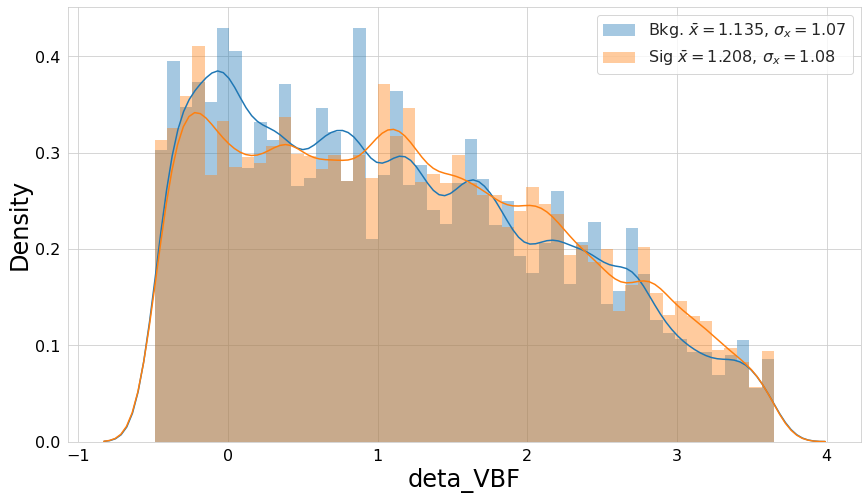

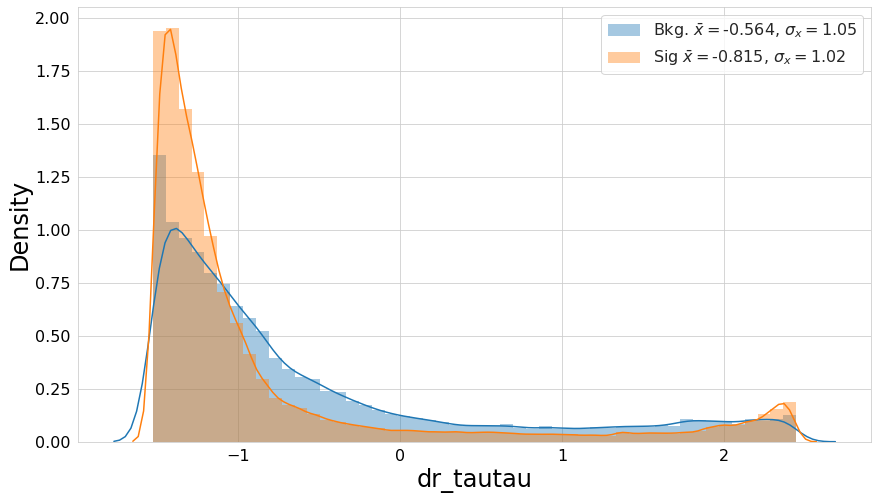

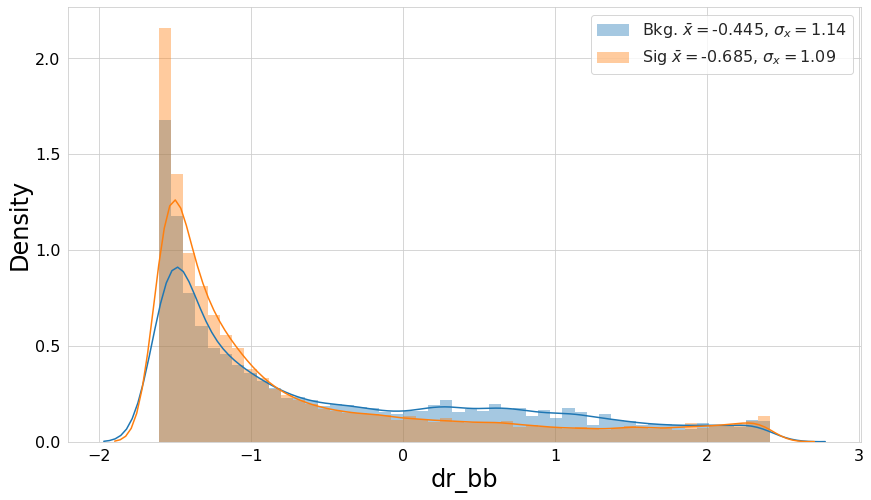

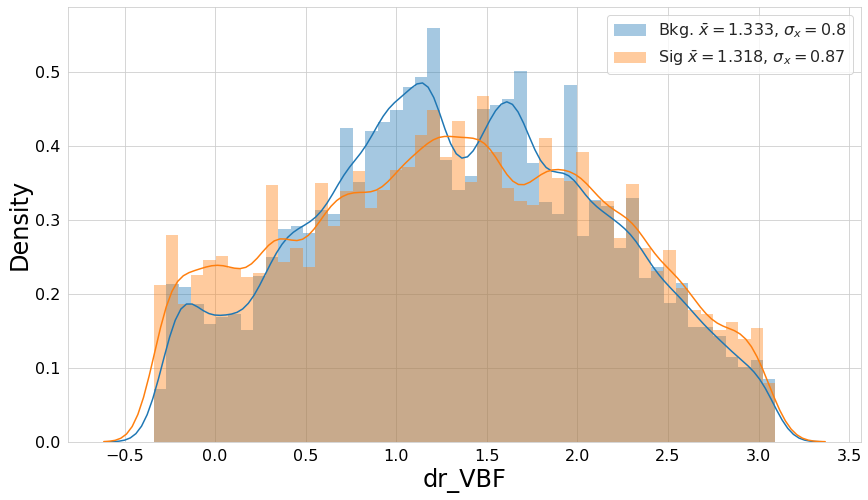

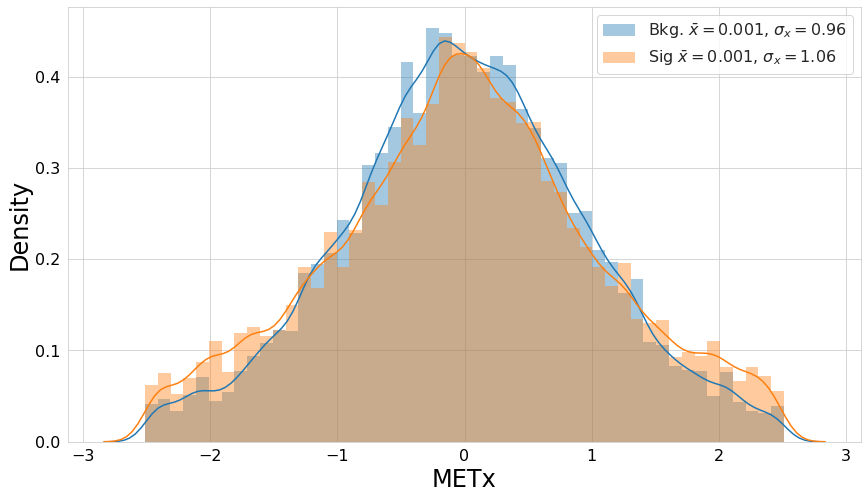

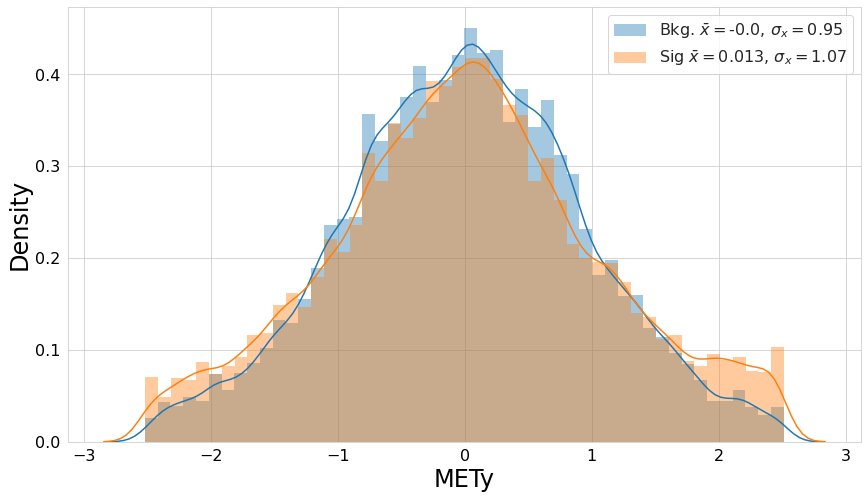

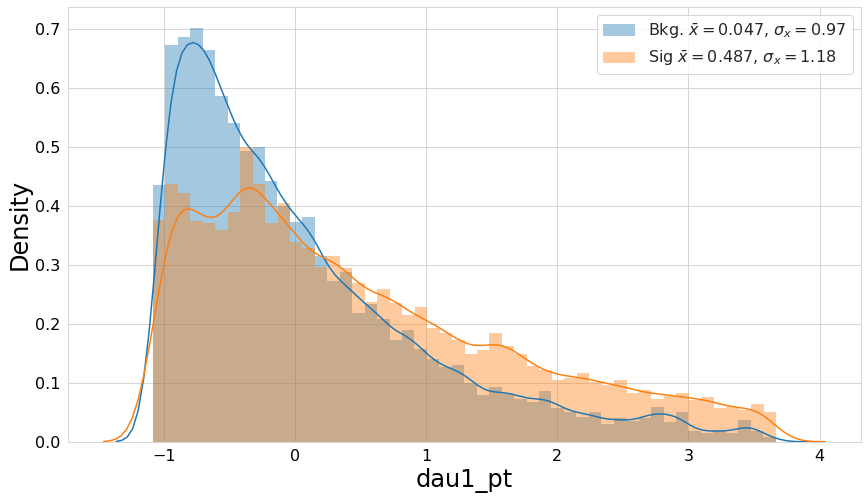

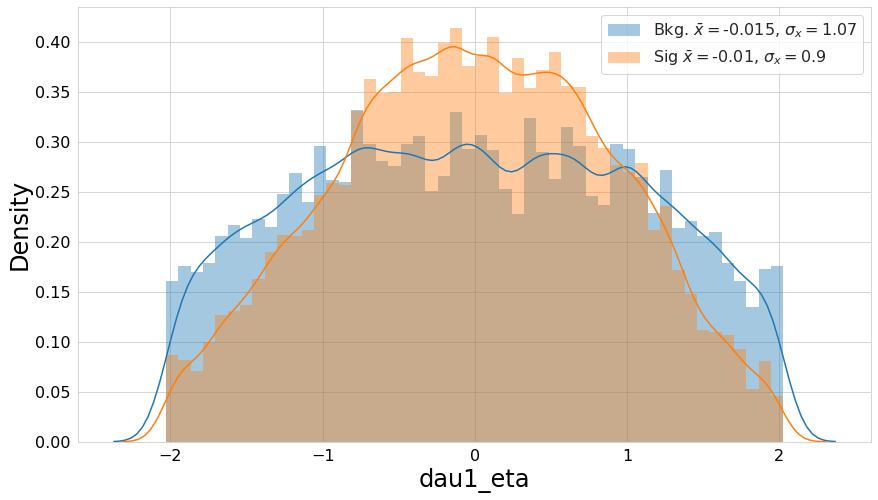

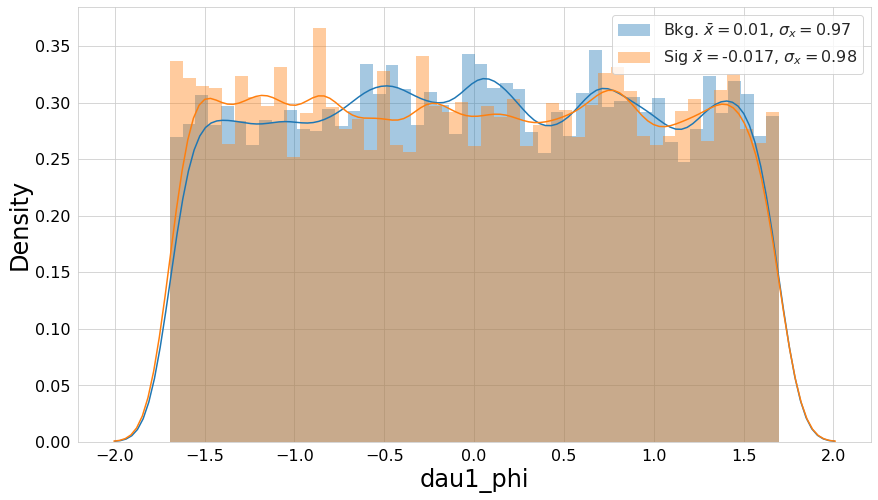

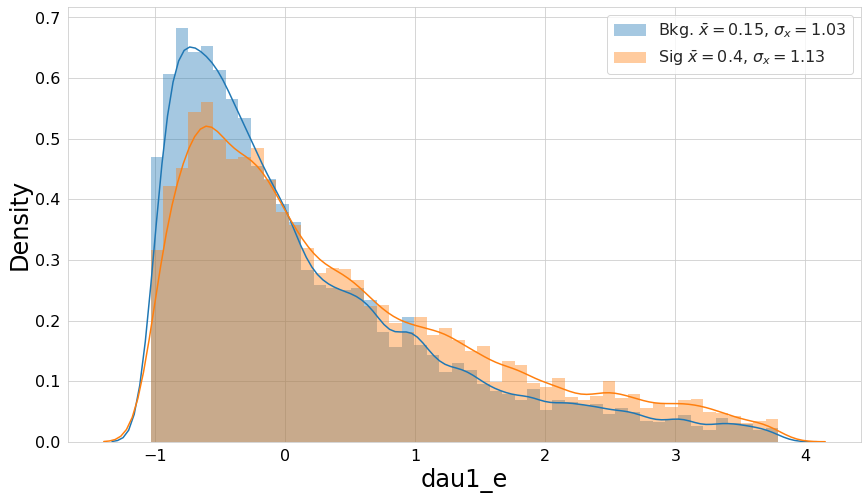

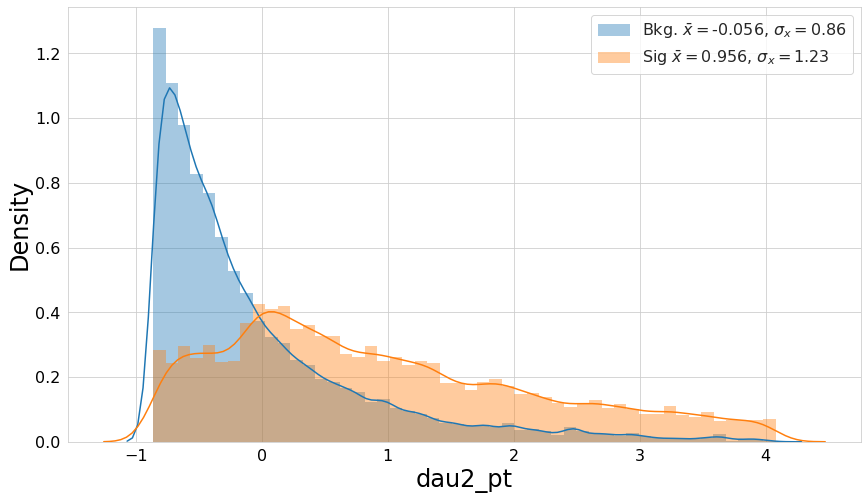

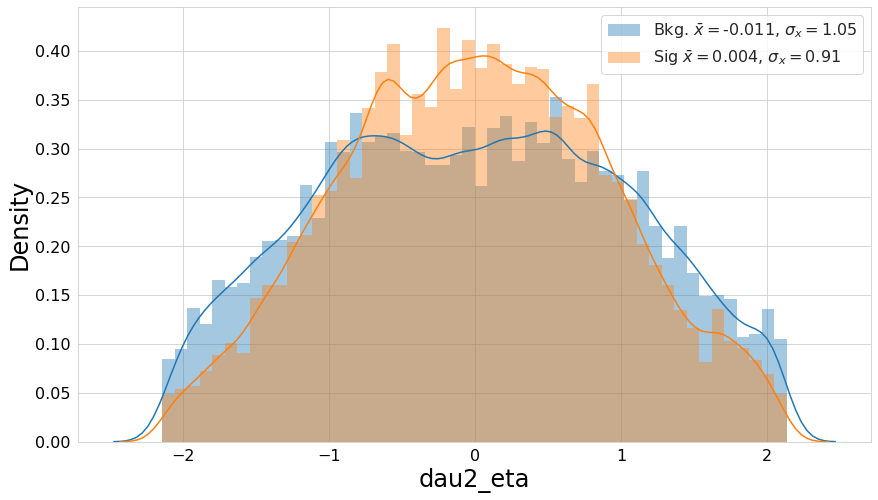

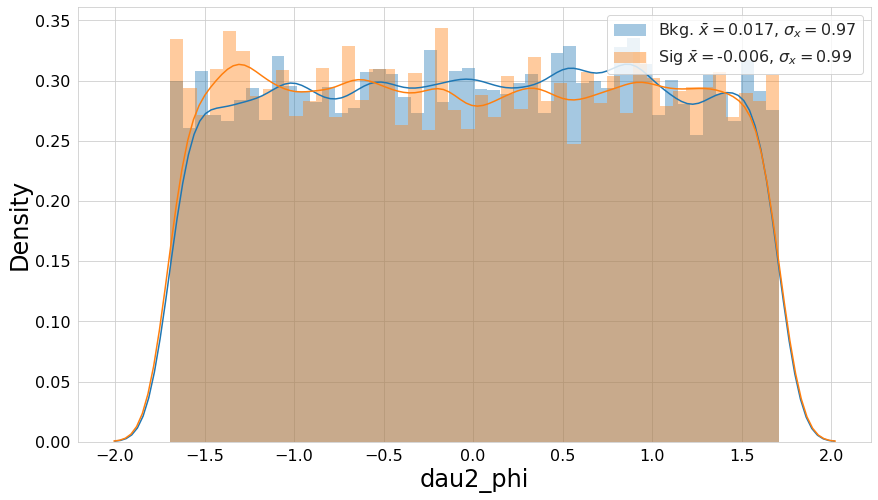

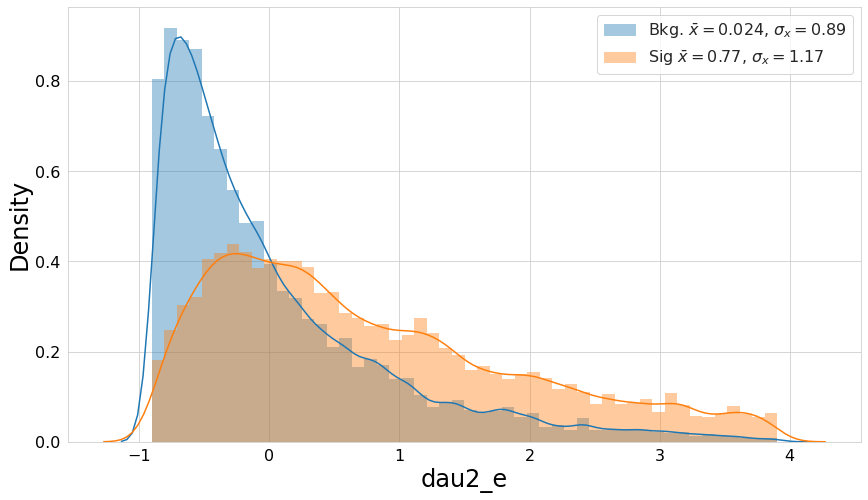

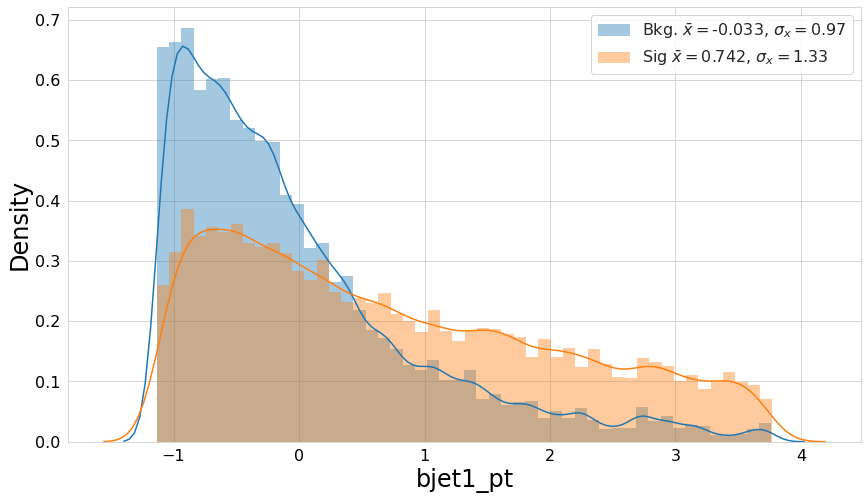

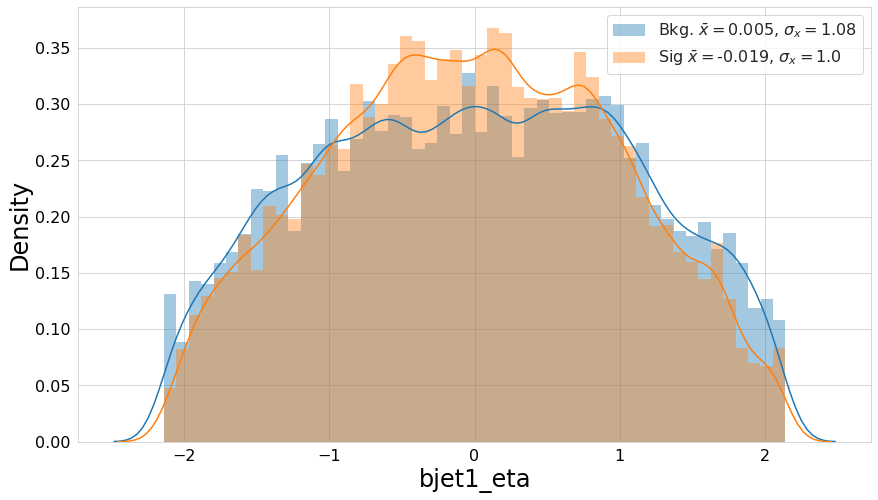

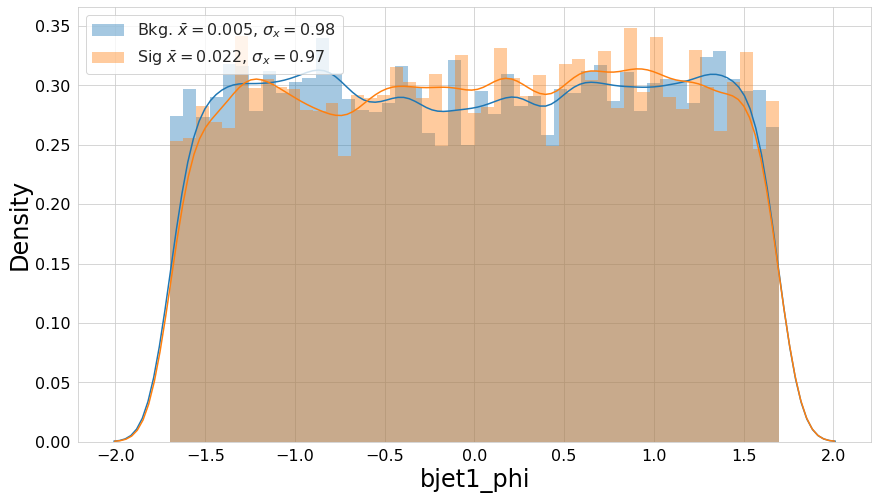

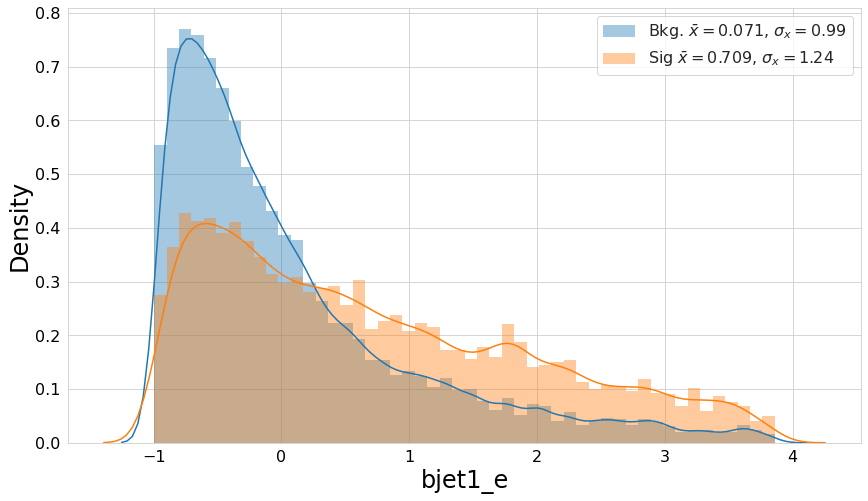

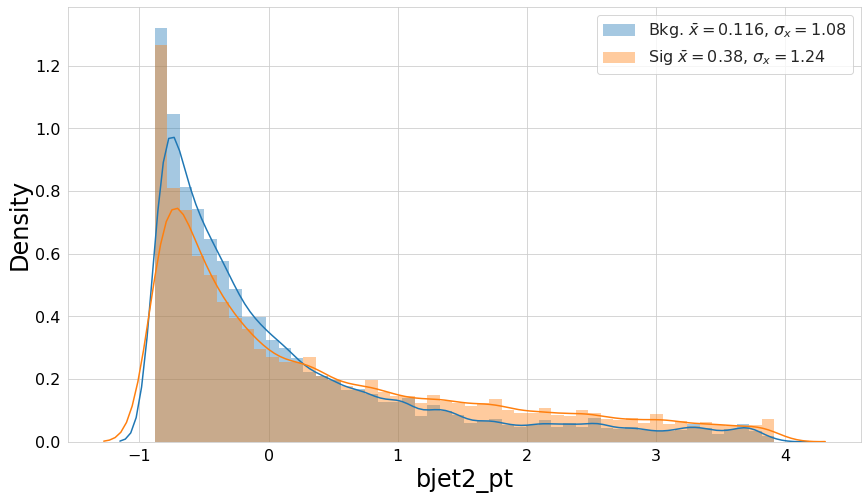

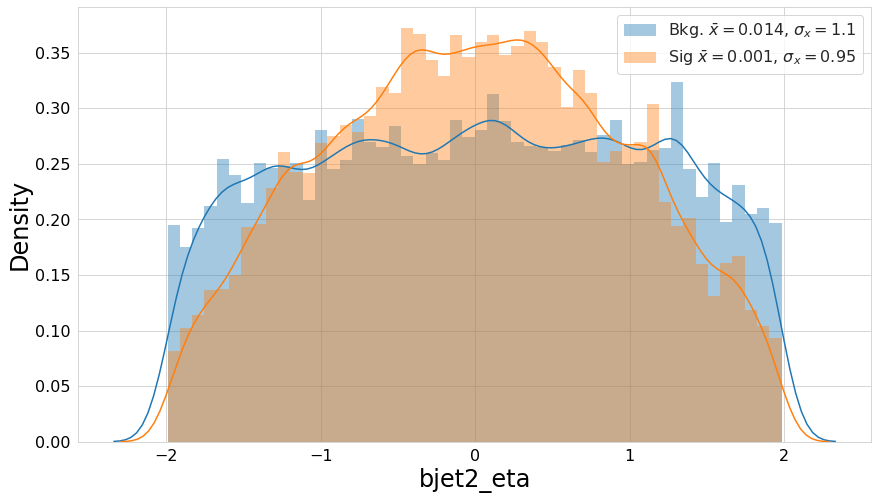

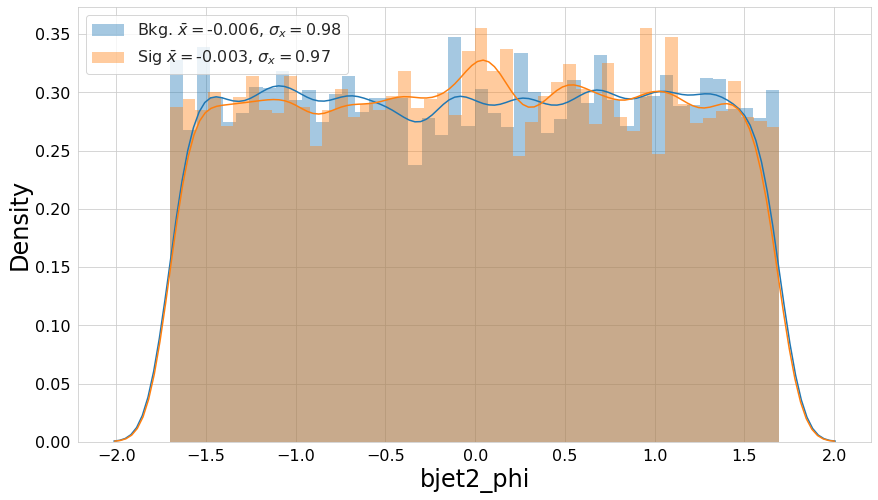

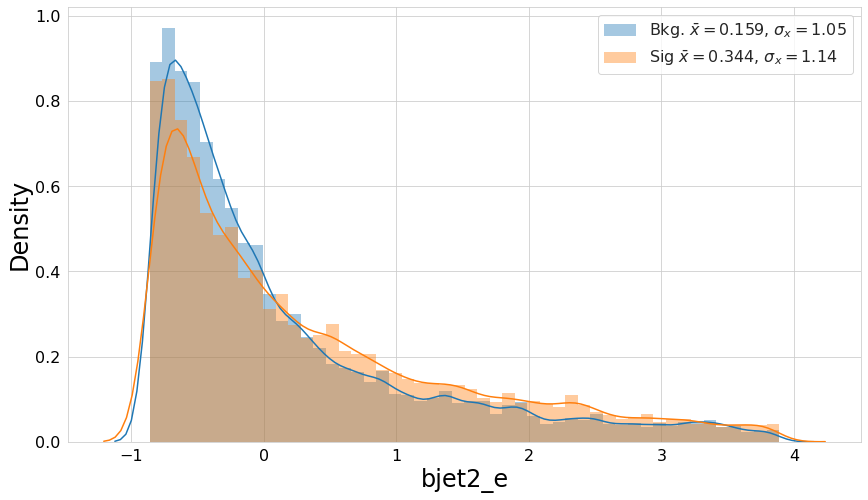

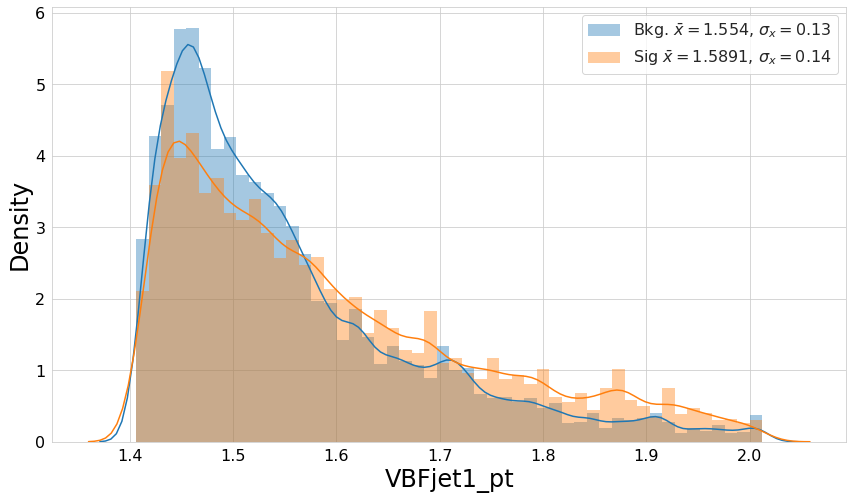

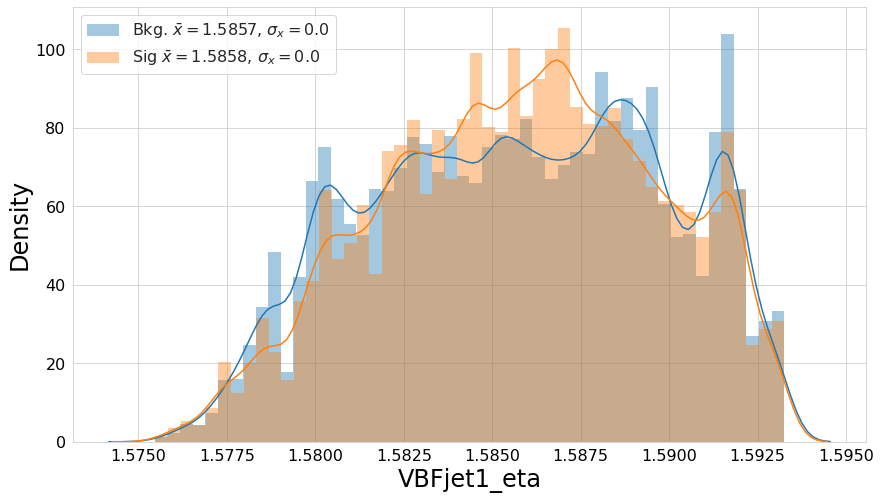

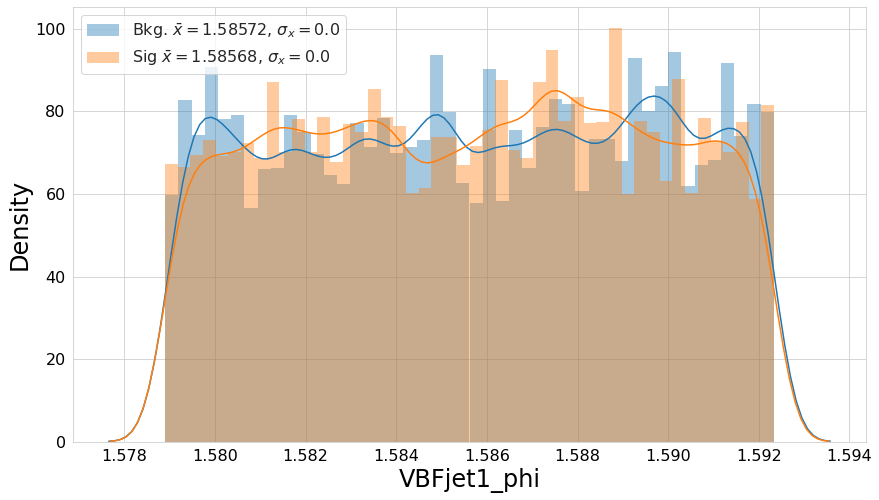

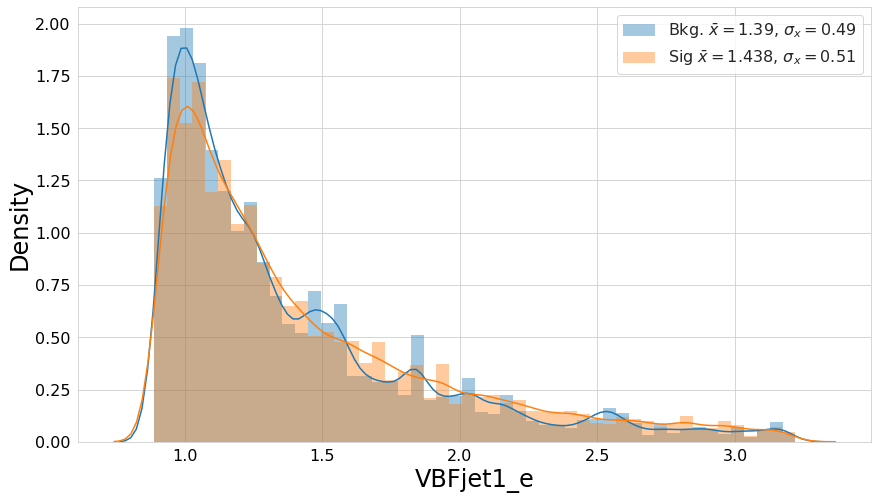

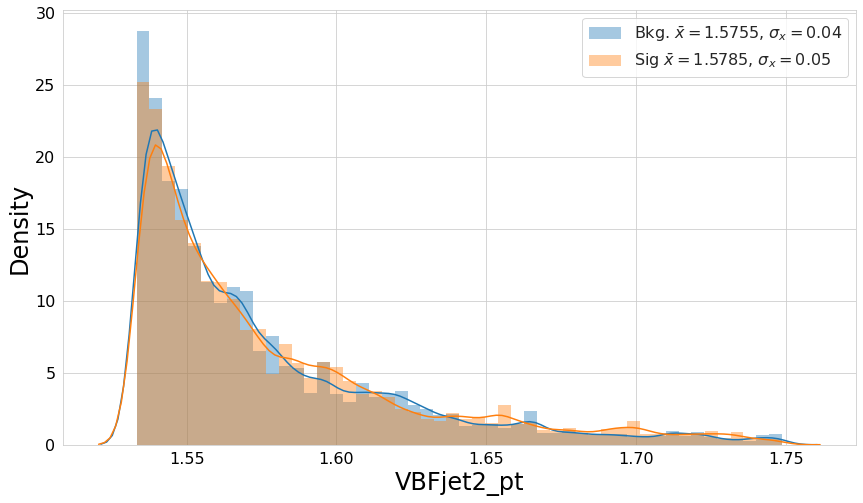

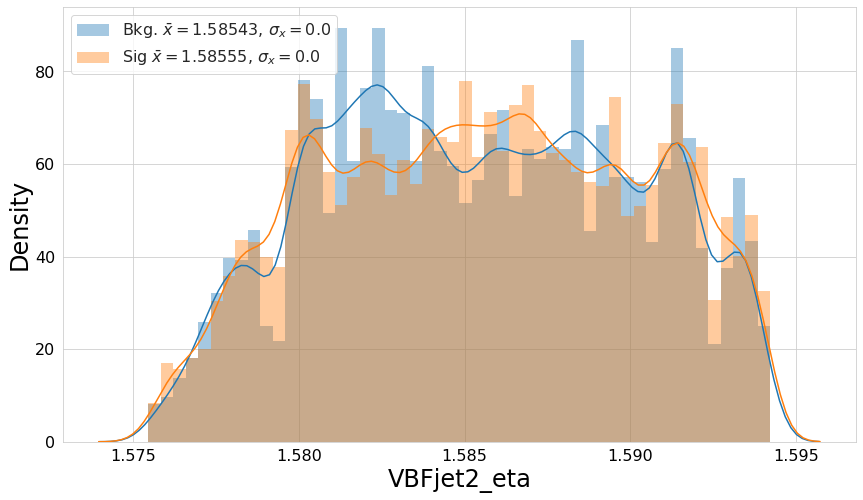

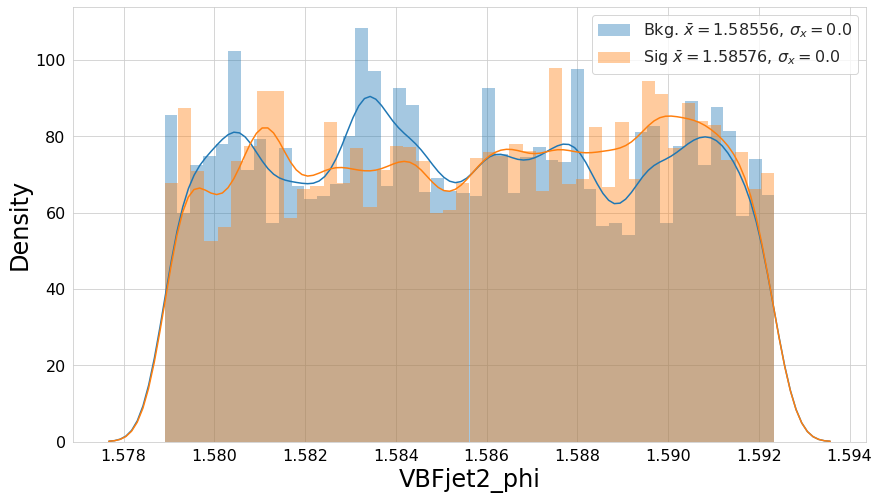

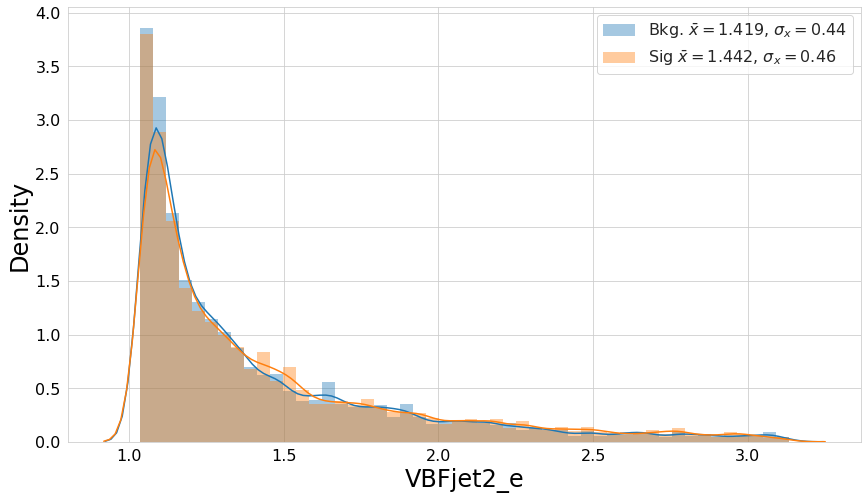

In [52]:
for feature in train_feats:
#for feature in cont_feats:
#for feature in cat_feats:
    plot_feat(Events_train, feature, cuts=[(Events_train.Class==0),(Events_train.Class==1)], labels=['Bkg.','Sig'], wgt_name='w_planing')

### Categorical features handling (for embedding)

In [53]:
from lumin.data_processing.pre_proc import proc_cats
cat_maps, cat_szs = proc_cats(Events_train, cat_feats, Events_test)
cat_maps, cat_szs

(OrderedDict([('dau1_decayMode', {0: -1, 1: 0, 2: 1, 3: 10, 4: 11}),
              ('dau2_decayMode', {0: 0, 1: 1, 2: 10, 3: 11})]),
 OrderedDict([('dau1_decayMode', 5), ('dau2_decayMode', 4)]))

### Cross-training folds generation

In [54]:
from lumin.data_processing.file_proc import df2foldfile
df2foldfile(df=Events_train, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats=[targ_class,targ_mass],
            wgt_feat=weight_feat, misc_feats='',
            savename='/data_CMS/cms/portales/HHresonant_DANNlumin/train', targ_type='float32', strat_key='Class')

df2foldfile(df=Events_test, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats=[targ_class,targ_mass],
            wgt_feat=weight_feat, misc_feats='',
            savename='/data_CMS/cms/portales/HHresonant_DANNlumin/test', targ_type='float32', strat_key='Class')

Saving fold 0 with 278957 events
Saving fold 1 with 278957 events
Saving fold 2 with 278957 events
Saving fold 3 with 278957 events
Saving fold 4 with 278957 events
Saving fold 5 with 278957 events
Saving fold 6 with 278957 events
Saving fold 7 with 278957 events
Saving fold 8 with 278957 events
Saving fold 9 with 278957 events
Saving fold 0 with 69740 events
Saving fold 1 with 69740 events
Saving fold 2 with 69740 events
Saving fold 3 with 69739 events
Saving fold 4 with 69739 events
Saving fold 5 with 69739 events
Saving fold 6 with 69739 events
Saving fold 7 with 69739 events
Saving fold 8 with 69739 events
Saving fold 9 with 69739 events


### Feature importance check

Optimising RF parameters


Evalualting importances


Top ten most important features:
                   Feature  Importance
7   tauHsvfitMet_deltaPhi    0.034433
3         tauH_SVFIT_mass    0.023743
1                 dau2_pt    0.020706
14               bjet1_pt    0.018302
2              HHKin_chi2    0.012776
5                 dau1_pt    0.012560
0          HHKin_mass_raw    0.011174
4                     mT1    0.010245
11                bH_mass    0.010234
8               dr_tautau    0.009853


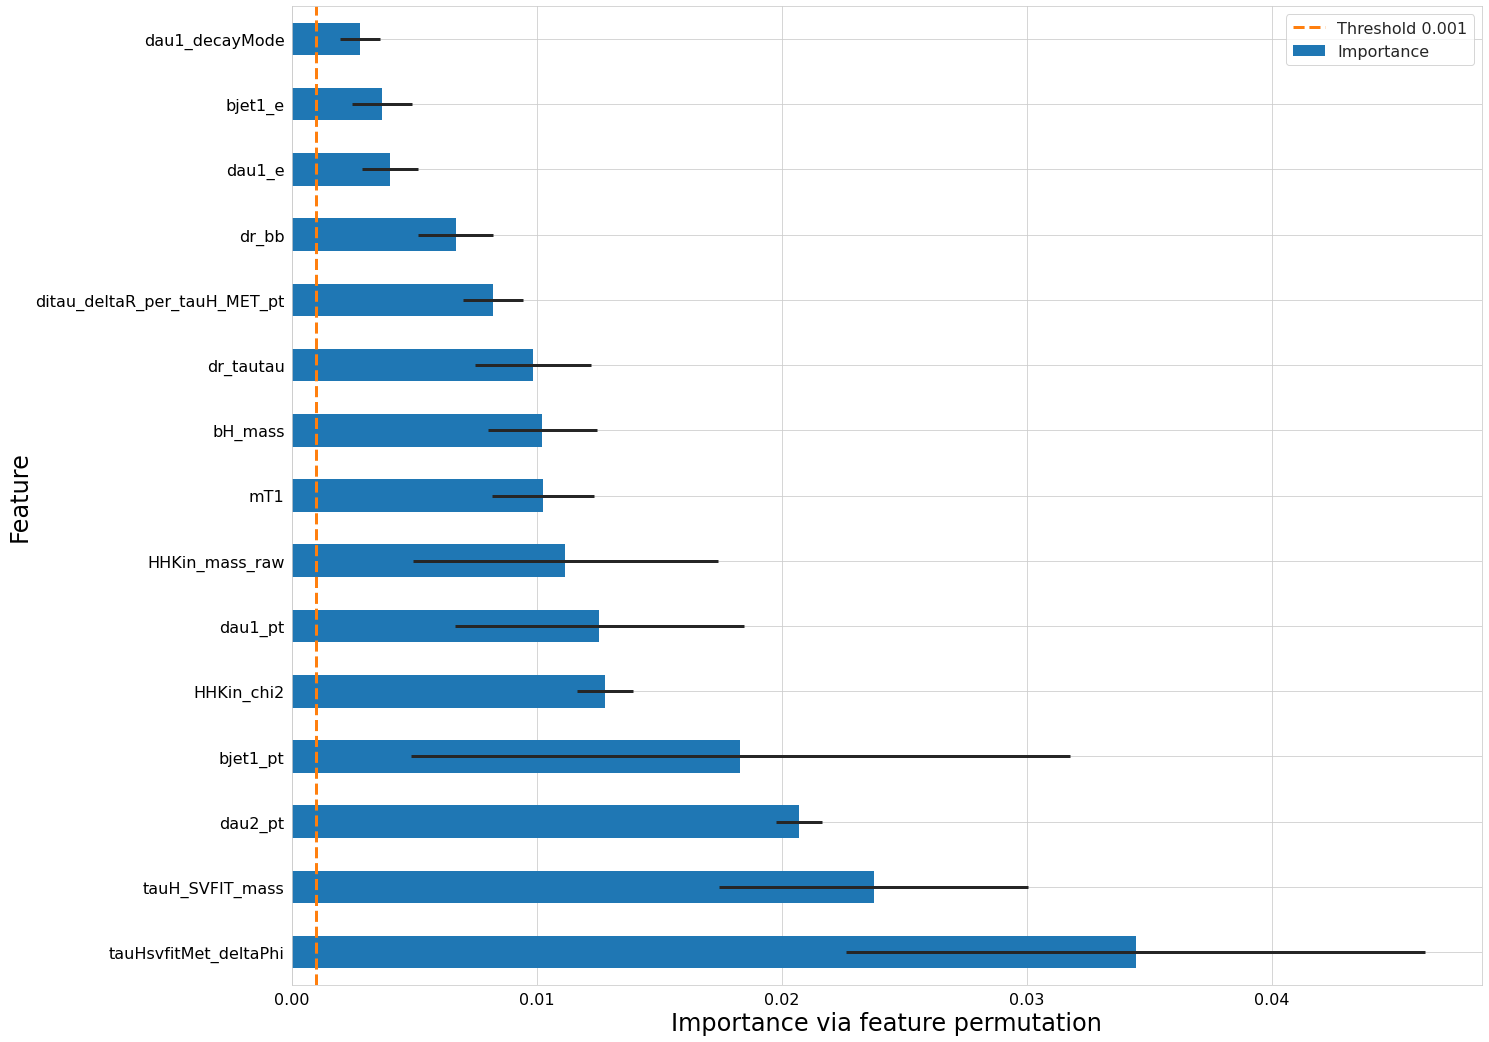


15 features found with importance greater than 0.001:
 ['tauHsvfitMet_deltaPhi', 'tauH_SVFIT_mass', 'dau2_pt', 'bjet1_pt', 'HHKin_chi2', 'dau1_pt', 'HHKin_mass_raw', 'mT1', 'bH_mass', 'dr_tautau', 'ditau_deltaR_per_tauH_MET_pt', 'dr_bb', 'dau1_e', 'bjet1_e', 'dau1_decayMode'] 

All training features found to be important


In [56]:
# this takes a little while
from lumin.optimisation.features import rf_rank_features
trainFeats_tested = ['HHKin_chi2', 'tauH_SVFIT_mass', 'dau2_pt', 'HHKin_mass_raw', 'dr_tautau', 'tauHsvfitMet_deltaPhi', 'ditau_deltaR_per_tauH_MET_pt', 'bH_mass', 'dau1_pt', 'mT1', 'dau1_decayMode', 'bjet1_pt', 'bjet1_e', 'dr_bb', 'dau1_e'] 
import_feats = rf_rank_features(Events_train, Events_test, objective='classification', train_feats=trainFeats_tested, targ_name='Class',
                                importance_cut=0.001, n_rfs=5, wgt_name='w_planing')